# CRM - PROPENSITY SCORING – Predicting Credit Card Adoption

## Project Goal

This project was developed with the data of an Italian banking group operating nationwide, with a strategic focus on northern Italy.  
In light of the launch of new credit card, the bank seeks to **identify clients most likely to adopt these offering**, using a **data-driven propensity scoring model**.

## Business Challenge

How can we predict which clients are more likely to purchase a credit card?

The bank has access to a wide range of structured client data, including:
- **Client demographics and registration info**
- **Wealth and asset-related indicators**
- **Product usage over time**
- **Detailed transaction behavior**

The key goal is to develop a machine learning model that translates these features into an actionable **propensity score**, which can guide:
- Marketing prioritization
- Personalization strategies
- Product cross-selling


## Project Overview

This notebook walks through the full end-to-end machine learning workflow for solving this problem, covering:

### 1. **Data Integration & Cleaning**
- Aggregation of client, transaction, product, and wealth datasets
- Feature engineering: seniority, volatility, ratios, behavioral patterns
- Removal of noisy or low-signal variables (e.g., overly sparse features)

### 2. **Feature Selection**
- Three independent methods: `SelectKBest`, `Lasso`, and `Random Forest Importance`
- Cross-method comparison and consensus filtering to retain top predictors

### 3. **Class Imbalance Handling**
- Application of SMOTE (Synthetic Minority Oversampling Technique) to balance the training set and prevent bias toward the majority class

### 4. **Modeling & Tuning**
- Training and evaluation of several classifiers:
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - Gradient Boosting
  - XGBoost
- Hyperparameter tuning via GridSearchCV (using ROC AUC as the primary metric)

### 5. **Evaluation & Interpretation**
- Comparison of all models on the test set (ROC AUC, precision, recall, F1-score)
- Feature importance visualization
- Confusion matrix and ROC curve analysis

### 6. **Scoring & Output**
- Generation of individual-level **propensity scores**
- Classification into `Low`, `Medium`, and `High` categories for marketing use
- Creation of a clean, interpretable output table for business stakeholders


## Deliverables

- A **trained and tuned propensity model** ready to score new clients
- An **interpretable framework** based on feature importance and ranking
- A **scalable pipeline** for future updates and model retraining
- Strategic guidance for the business on **who to target, and why**

This solution supports smarter, data-informed CRM strategies — allowing the bank to efficiently identify and engage clients with the highest likelihood of product adoption.


# PART 1:

# INITIAL EXPLORATORY DATA ANALYSIS (EDA) OF BANKING DATASETS:

### Understanding Customer Profiles, Products, Transfers, and Wealth

**Objective**:  
This notebook aims to perform an **initial exploratory data analysis (EDA)** on four banking datasets to understand their structure, distributions, and potential insights.  

**Datasets Used**:
- `BANK_CLIENT_clean.csv` → Customer demographic information
- `BANK_PRODUCTS_clean.csv` → Customer-owned banking products
- `BANK_TRANSFER_clean.csv` → Bank transfer transactions
- `BANK_WEALTH_clean.csv` → Wealth and investment details  

## Importing Libraries & Loading Data

In [216]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import datetime as datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import roc_curve, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from imblearn.over_sampling import SMOTE


# Set random state
random_state = 42   # Used to ensure reproducibility

# Set visualization style
sns.set_style("whitegrid")

# Loading datasets with your specific url
df_client = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\BANK_CLIENT_clean.csv")
df_products = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\BANK_PRODUCTS_clean.csv")
df_transfers = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\BANK_TRANSFER_clean.csv")
df_wealth = pd.read_csv(r"C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\BANK_WEALTH_clean.csv")

# Display the first few rows of each dataset
datasets = {"Clients": df_client, "Products": df_products, "Transfers": df_transfers, "Wealth": df_wealth}
for name, df in datasets.items():
    print(f"First 5 rows of {name} dataset:")
    display(df.head())
    print("\n" + "="*80 + "\n")

First 5 rows of Clients dataset:


,CUSTOMER_ID,REGISTRATION_DATE,DATE_OF_BIRTH,REGION,GENDER
0,DF00261884,2012-06-08,1987-09-29,EMILIA ROMAGNA,M
1,IQ00262656,2017-12-09,1984-06-07,SARDEGNA,M
2,QA00262675,2008-02-21,1975-07-28,CAMPANIA,F
3,IX00262687,2017-08-28,1970-04-11,VENETO,F
4,AA00263211,2001-12-02,1979-12-18,UMBRIA,M




First 5 rows of Products dataset:


,CUSTOMER_ID,MONTH,N_ACCT,N_MNG_ACCT,N_SAVING_DEPOSIT,N_BONDS,N_SHARES,N_FUNDS,N_LIFE_INSURANCE,N_MORTGAGE,N_FINANCING,N_WATER,N_LIGHT,N_GAS,N_TELEFONE,N_DEBIT_CARD,N_ONLINE_BANKING,N_CREDIT_CARD,N_SICAV_FUNDS,N_PENSION_FUNDS
0,DF00261884,201803.0,1,1,0,2,1,0,2,0,0,1,1,0,1,2,0,2,8,0
1,DF00261884,201804.0,1,1,0,2,1,0,2,0,0,1,1,0,1,2,0,2,8,0
2,DF00261884,201805.0,1,1,0,1,1,0,2,0,0,1,1,0,1,2,0,2,8,0
3,DF00261884,201806.0,1,1,0,1,1,0,3,0,0,1,1,0,1,2,0,2,8,0
4,DF00261884,201807.0,1,1,0,1,1,0,3,0,0,1,1,1,1,2,0,2,8,0




First 5 rows of Transfers dataset:


,MONTH,TRANSFER_TYPE_DES,CUSTOMER_ID,AM_CREDIT,AM_DEBIT,NUM_CREDIT,NUM_DEBIT
0,201803.0,DEPOSITS,JK00818603,0.0,0.0,0.0,0.0
1,201803.0,PENSIONS_SALARY,DM00923868,1270.0,0.0,1.0,0.0
2,201803.0,TRANSFERS_IN,QD00651127,2600.0,0.0,2.0,0.0
3,201803.0,PENSIONS_SALARY,TR00667485,779.0,0.0,1.0,0.0
4,201803.0,DEPOSITS,OO00623012,0.0,0.0,0.0,0.0




First 5 rows of Wealth dataset:


,CUSTOMER_ID,MONTH,TOT_DIRECT_DEPOSIT,TOT_ASSETS_UNDER_CUSTODY,TOT_MNG_DEPOSIT,TOT_INVESTMENTS
0,ON00631111,201804,10975.0,0.0,0.0,0.0
1,ON00631111,201805,10934.0,0.0,0.0,0.0
2,ON00631111,201806,10817.0,0.0,0.0,0.0
3,ON00631111,201807,10776.0,0.0,0.0,0.0
4,ON00631111,201808,10133.0,0.0,0.0,0.0


## Basic Data Overview

In this section, we check:
- The **number of rows and columns** (`.shape`)
- The **structure** of the datasets (`.info()`)
- Basic **summary statistics** (`.describe()`)
- The **number of missing values**

In [167]:
# Display dataset structure, shape, and summary statistics
for name, df in datasets.items():
    print("\n" + "="*80)
    print(f"Dataset: {name}")
    print(f"Shape: {df.shape[0]} rows, {df.shape[1]} columns")  # Shows number of rows & columns
    print("\nStructure:")
    display(df.info())  # Shows column data types and missing values
    print("\nSummary Statistics:")
    display(df.describe())  # Shows summary statistics for numerical columns
    print("="*80 + "\n")


Dataset: Clients
Shape: 14241 rows, 5 columns

Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14241 entries, 0 to 14240
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CUSTOMER_ID        14241 non-null  object
 1   REGISTRATION_DATE  14241 non-null  object
 2   DATE_OF_BIRTH      14241 non-null  object
 3   REGION             14241 non-null  object
 4   GENDER             14241 non-null  object
dtypes: object(5)
memory usage: 556.4+ KB


None


Summary Statistics:


,CUSTOMER_ID,REGISTRATION_DATE,DATE_OF_BIRTH,REGION,GENDER
count,14241,14241,14241,14241,14241
unique,14241,5724,8558,20,2
top,BI01129496,2017-07-11,1985-04-07,LAZIO,M
freq,1,14,76,1874,7368




Dataset: Products
Shape: 180576 rows, 20 columns

Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180576 entries, 0 to 180575
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CUSTOMER_ID       180576 non-null  object 
 1   MONTH             180576 non-null  float64
 2   N_ACCT            180576 non-null  int64  
 3   N_MNG_ACCT        180576 non-null  int64  
 4   N_SAVING_DEPOSIT  180576 non-null  int64  
 5   N_BONDS           180576 non-null  int64  
 6   N_SHARES          180576 non-null  int64  
 7   N_FUNDS           180576 non-null  int64  
 8   N_LIFE_INSURANCE  180576 non-null  int64  
 9   N_MORTGAGE        180576 non-null  int64  
 10  N_FINANCING       180576 non-null  int64  
 11  N_WATER           180576 non-null  int64  
 12  N_LIGHT           180576 non-null  int64  
 13  N_GAS             180576 non-null  int64  
 14  N_TELEFONE        180576 non-null  int64  
 15  N_DEB

None


Summary Statistics:


,MONTH,N_ACCT,N_MNG_ACCT,N_SAVING_DEPOSIT,N_BONDS,N_SHARES,N_FUNDS,N_LIFE_INSURANCE,N_MORTGAGE,N_FINANCING,N_WATER,N_LIGHT,N_GAS,N_TELEFONE,N_DEBIT_CARD,N_ONLINE_BANKING,N_CREDIT_CARD,N_SICAV_FUNDS,N_PENSION_FUNDS
count,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000,180576.000000
mean,201829.576793,1.127835,1.032341,0.122242,0.754015,0.788549,0.167663,0.356194,0.107589,0.100822,0.056962,0.370398,0.141968,0.368559,0.822839,0.072069,0.413665,1.244329,0.002874
std,40.040738,0.528375,0.588830,0.617900,1.540412,2.533297,0.492153,0.822795,0.325634,0.333869,0.244514,0.529401,0.369549,0.525102,0.714733,0.258689,0.742186,2.323565,0.053534
min,201803.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,201806.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,201809.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,201812.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000
max,201903.000000,6.000000,6.000000,31.000000,33.000000,51.000000,9.000000,16.000000,7.000000,3.000000,3.000000,3.000000,3.000000,3.000000,7.000000,3.000000,10.000000,53.000000,1.000000




Dataset: Transfers
Shape: 691816 rows, 7 columns

Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691816 entries, 0 to 691815
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              691816 non-null  float64
 1   TRANSFER_TYPE_DES  352494 non-null  object 
 2   CUSTOMER_ID        691816 non-null  object 
 3   AM_CREDIT          691816 non-null  float64
 4   AM_DEBIT           691816 non-null  float64
 5   NUM_CREDIT         691816 non-null  float64
 6   NUM_DEBIT          691816 non-null  float64
dtypes: float64(5), object(2)
memory usage: 36.9+ MB


None


Summary Statistics:


,MONTH,AM_CREDIT,AM_DEBIT,NUM_CREDIT,NUM_DEBIT
count,691816.000000,6.918160e+05,6.918160e+05,691816.000000,691816.000000
mean,201829.357200,5.710315e+02,5.541438e+02,0.235287,1.414756
std,39.678366,9.914219e+03,8.149430e+03,0.791127,2.939737
min,201803.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,201806.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,201809.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,201812.000000,0.000000e+00,1.300000e+02,0.000000,1.000000
max,201903.000000,4.289092e+06,1.451300e+06,80.000000,135.000000




Dataset: Wealth
Shape: 180576 rows, 6 columns

Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180576 entries, 0 to 180575
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CUSTOMER_ID               180576 non-null  object 
 1   MONTH                     180576 non-null  int64  
 2   TOT_DIRECT_DEPOSIT        180576 non-null  float64
 3   TOT_ASSETS_UNDER_CUSTODY  180576 non-null  float64
 4   TOT_MNG_DEPOSIT           180576 non-null  float64
 5   TOT_INVESTMENTS           180576 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 8.3+ MB


None


Summary Statistics:


,MONTH,TOT_DIRECT_DEPOSIT,TOT_ASSETS_UNDER_CUSTODY,TOT_MNG_DEPOSIT,TOT_INVESTMENTS
count,180576.000000,1.805760e+05,1.805760e+05,1.805760e+05,180576.000000
mean,201829.576793,3.318563e+04,2.112412e+04,2.958205e+04,7170.979643
std,40.040738,9.120417e+04,8.639073e+04,8.003089e+04,25040.274173
min,201803.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,201806.000000,1.479000e+03,0.000000e+00,0.000000e+00,0.000000
50%,201809.000000,8.401000e+03,0.000000e+00,5.910000e+02,0.000000
75%,201812.000000,3.430225e+04,4.981000e+03,2.657900e+04,0.000000
max,201903.000000,5.515419e+06,2.899670e+06,3.138968e+06,564492.000000


## Checking for Missing Values

We check for missing values in each dataset.  
 
- To improve readability, only columns with missing values will be displayed.
- A custom function missing_values_report() is used for better formatting.

In [168]:
# Function to display missing values in a clean format
def missing_values_report(df, dataset_name):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]  # Show only columns with missing values

    if missing_values.empty:
        print(f" No missing values in {dataset_name} dataset.\n")
    else:
        print(f" Missing values found in {dataset_name} dataset:\n")
        display(pd.DataFrame(missing_values, columns=["Missing Values"]))

# Apply function to all datasets
for name, df in datasets.items():
    print("\n" + "="*80)
    missing_values_report(df, name)
    print("="*80 + "\n")


 No missing values in Clients dataset.



 No missing values in Products dataset.



 Missing values found in Transfers dataset:



,Missing Values
TRANSFER_TYPE_DES,339322




 No missing values in Wealth dataset.




## Outlier Detection Using the IQR Method

Outliers are extreme values that fall outside a typical range in the dataset.  
we detect them using the **Interquartile Range (IQR)** method across all numerical columns in each dataset.

### **How Outliers Are Identified?**
- **IQR = Q3 - Q1** (Interquartile Range)
- **Lower Bound** = Q1 - 1.5 * IQR
- **Upper Bound** = Q3 + 1.5 * IQR
- Any value **outside these bounds** is considered an outlier.

### **What is Deviation?**
- Deviation measures **how far an outlier is from the nearest boundary**.

- If `x > upper_bound` → Deviation = `x − upper_bound`
- If `x < lower_bound` → Deviation = `lower_bound − x`

- **Example**: If the **upper bound** is 10,000 and an outlier is 15,000 →  
  **Deviation = 5,000** (15,000 - 10,000).
- **How to interpret the average deviation?**  
  - A **low average deviation** suggests that outliers are **only slightly outside the boundary**.  
  - A **high average deviation** means that outliers are **far from the normal range**


In [169]:
def detect_outliers(df, column):
    """Detect outliers in a numeric column using the IQR method and measure their deviation."""
    Q1 = df[column].quantile(0.25)  # First Quartile
    Q3 = df[column].quantile(0.75)  # Third Quartile
    IQR = Q3 - Q1  # Interquartile Range

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)].copy()

    # Measure deviation (distance from lower or upper bound)
    outliers["Deviation"] = outliers[column].apply(lambda x:
                        round(abs(x - lower_bound), 2) if x < lower_bound else round(abs(x - upper_bound), 2))

    return outliers  # Return full dataframe of outliers

# Define datasets
datasets = {
    "BANK_CLIENT_clean": df_client,
    "BANK_PRODUCTS_clean": df_products,
    "BANK_TRANSFER_clean": df_transfers,
    "BANK_WEALTH_clean": df_wealth
}

# Iterate through datasets and detect outliers
for name, df in datasets.items():
    print("\n" + "="*70)
    print(f"  OUTLIER ANALYSIS FOR: {name}")
    print("="*70)

    num_cols = df.select_dtypes(include=['number']).columns  # Select numeric columns
    outlier_summary = {}

    for col in num_cols:
        outlier_data = detect_outliers(df, col)
        outlier_count = outlier_data.shape[0]  # Number of outliers

        if outlier_count > 0:  # Only show columns with actual outliers
            avg_deviation = round(outlier_data["Deviation"].mean(), 2)  # Average deviation
            max_deviation = round(outlier_data["Deviation"].max(), 2)  # Max deviation
            min_deviation = round(outlier_data["Deviation"].min(), 2)  # Min deviation

            outlier_summary[col] = [outlier_count, avg_deviation, max_deviation, min_deviation]

    # Convert results into a DataFrame
    outlier_df = pd.DataFrame.from_dict(outlier_summary, orient="index",
                                        columns=["Total Outliers", "Avg Deviation", "Max Deviation", "Min Deviation"]).T

    # Display the table if there are outliers, otherwise print a message
    if not outlier_df.empty:
        print(outlier_df.to_string(index=True))  # Print table with column names
    else:
        print(" No outliers detected in this dataset.")


  OUTLIER ANALYSIS FOR: BANK_CLIENT_clean
 No outliers detected in this dataset.

  OUTLIER ANALYSIS FOR: BANK_PRODUCTS_clean
                  MONTH    N_ACCT  N_MNG_ACCT  N_SAVING_DEPOSIT   N_BONDS  N_SHARES   N_FUNDS  N_LIFE_INSURANCE  N_MORTGAGE  N_FINANCING  N_WATER  N_LIGHT     N_GAS  N_TELEFONE  N_DEBIT_CARD  N_ONLINE_BANKING  N_CREDIT_CARD  N_SICAV_FUNDS  N_PENSION_FUNDS
Total Outliers  42143.0  37878.00    49368.00          15628.00  18386.00  38564.00  23386.00          41453.00    18706.00     16472.00  9742.00    155.0  24317.00       145.0       3446.00           13011.0         3440.0         9900.0            519.0
Avg Deviation      81.0      1.12        1.08              1.41      1.94      3.69      1.29              1.55        1.04         1.11     1.06      0.5      1.05         0.5          0.65               1.0            1.2            3.6              1.0
Max Deviation      82.0      5.00        5.00             31.00     30.50     51.00      9.00            

## Histograms of Numerical Variables

Histograms are used to **visualize the distribution** of numerical variables in each dataset.  
They provide insights into the **shape, spread, and potential skewness** of the data.

### Why Use Histograms?
-  Highlight possible **outliers**
-  Detect **data skewness** (left, right, multimodal)
-  Inform **preprocessing steps** like normalization or transformation

### Method
- All numerical columns are selected automatically.
- For each dataset:
  - Multiple histograms are arranged using subplots.
  - Each plot includes a **KDE curve** for smooth density estimation.
  - Layout adjusts dynamically based on the number of features.

If a dataset has **no numerical columns**, it's skipped automatically.

 No numerical columns available for histograms in BANK_CLIENT_clean


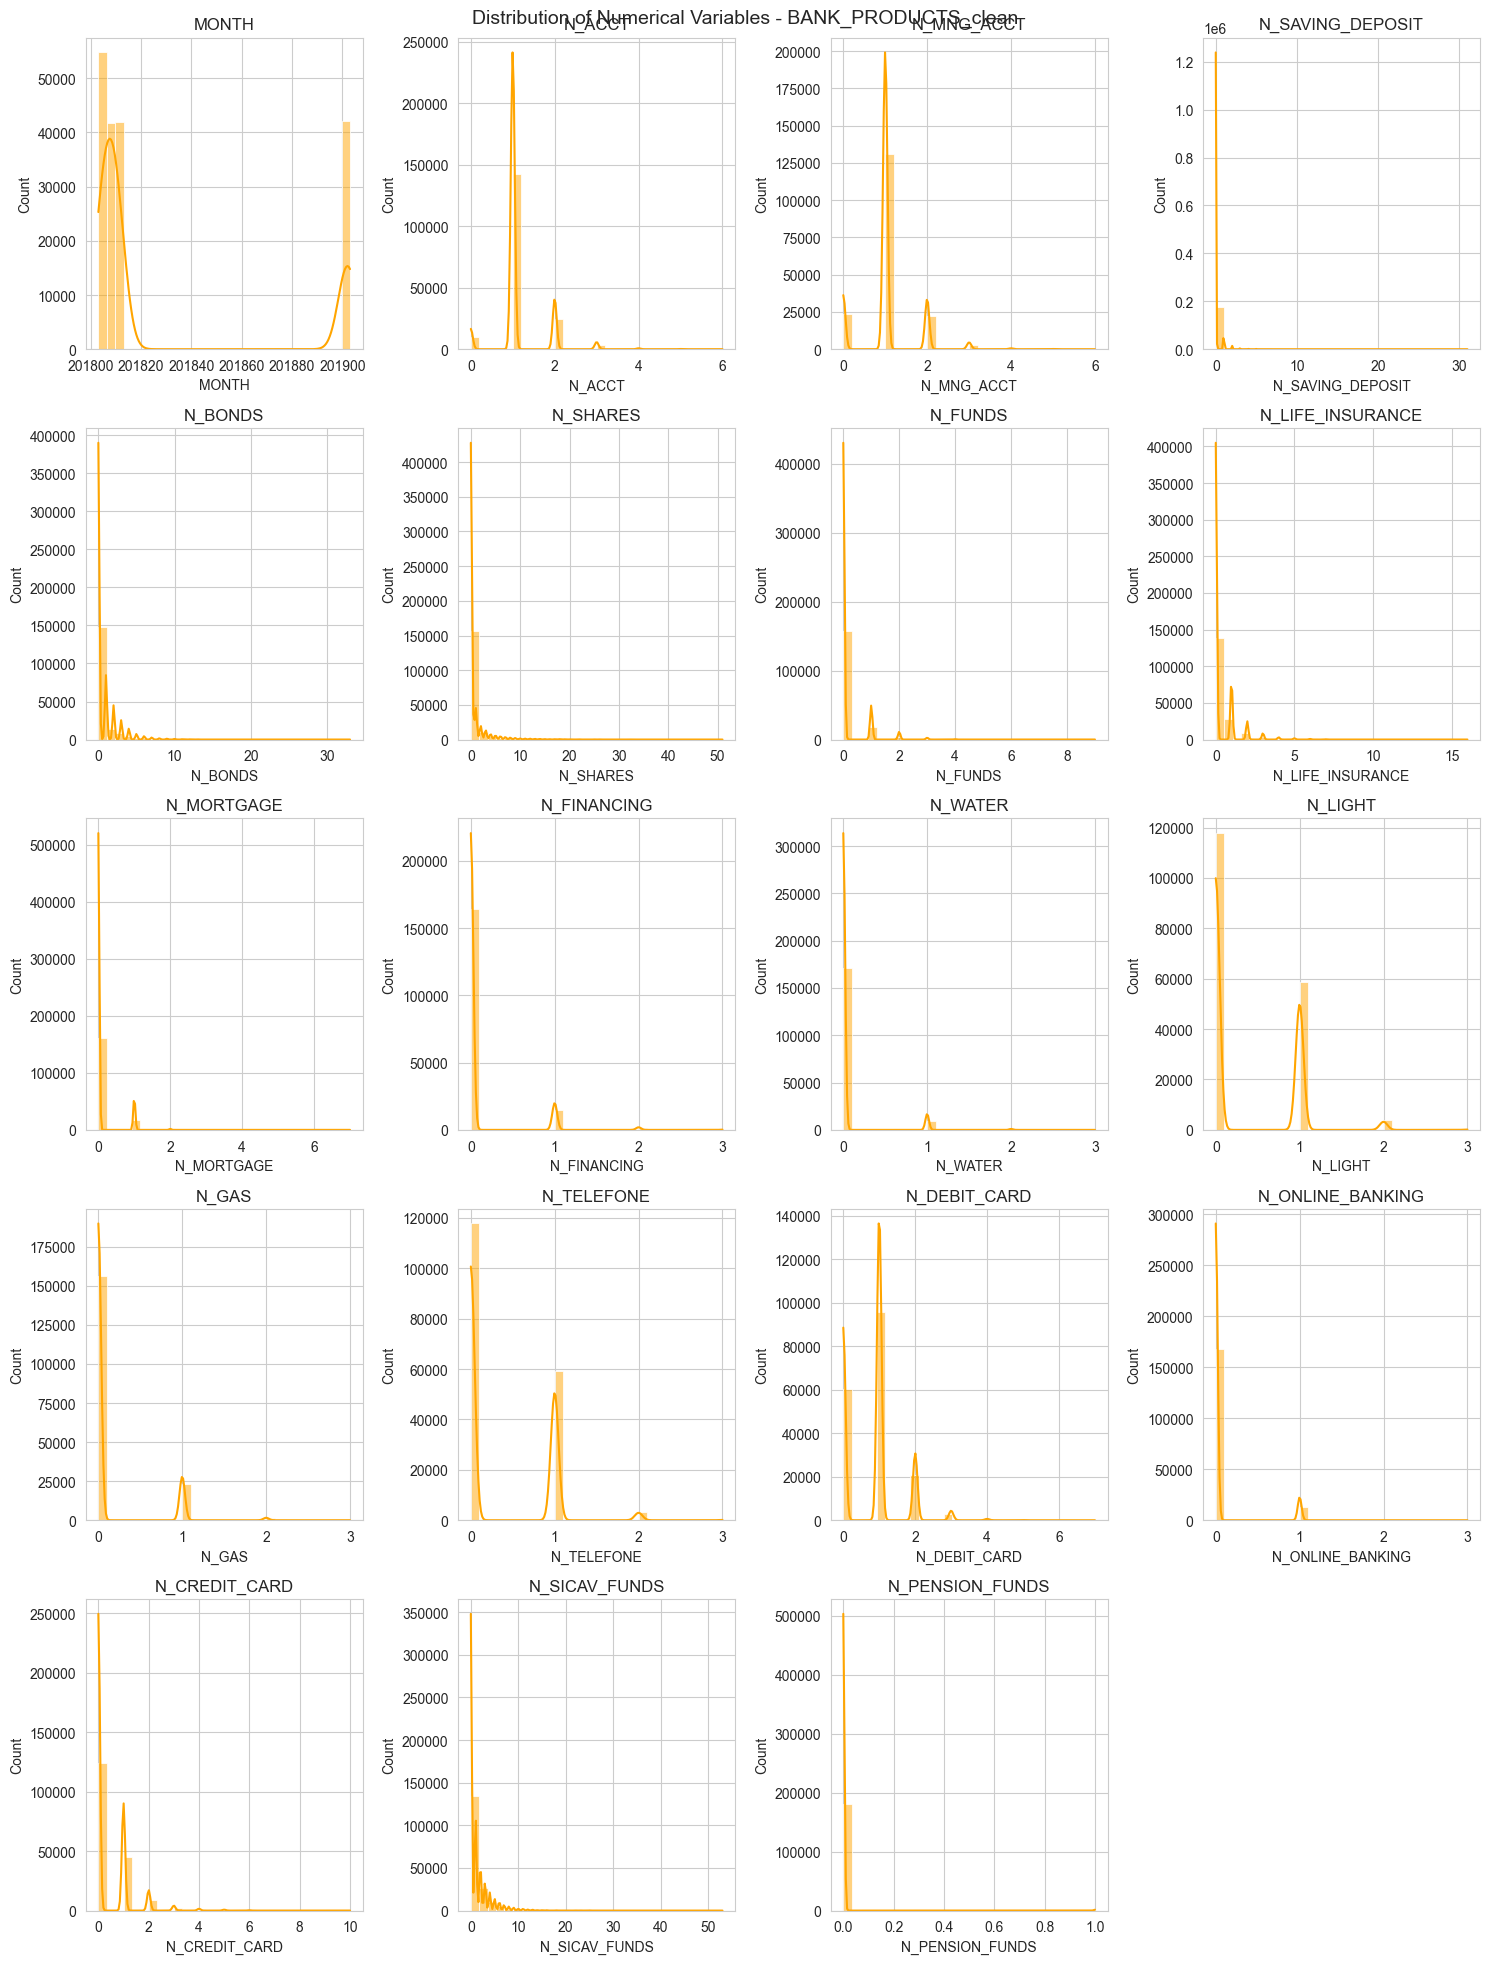

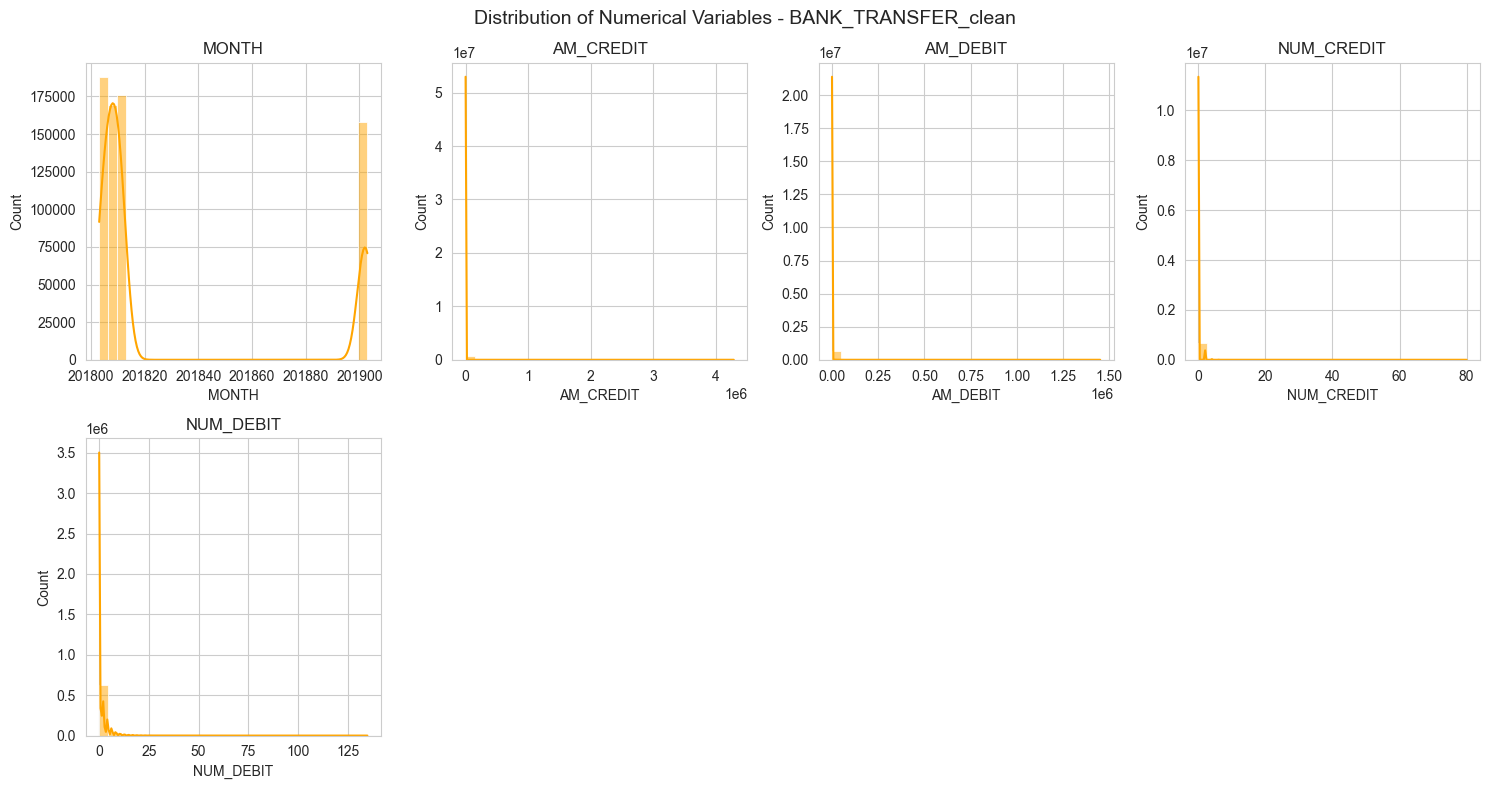

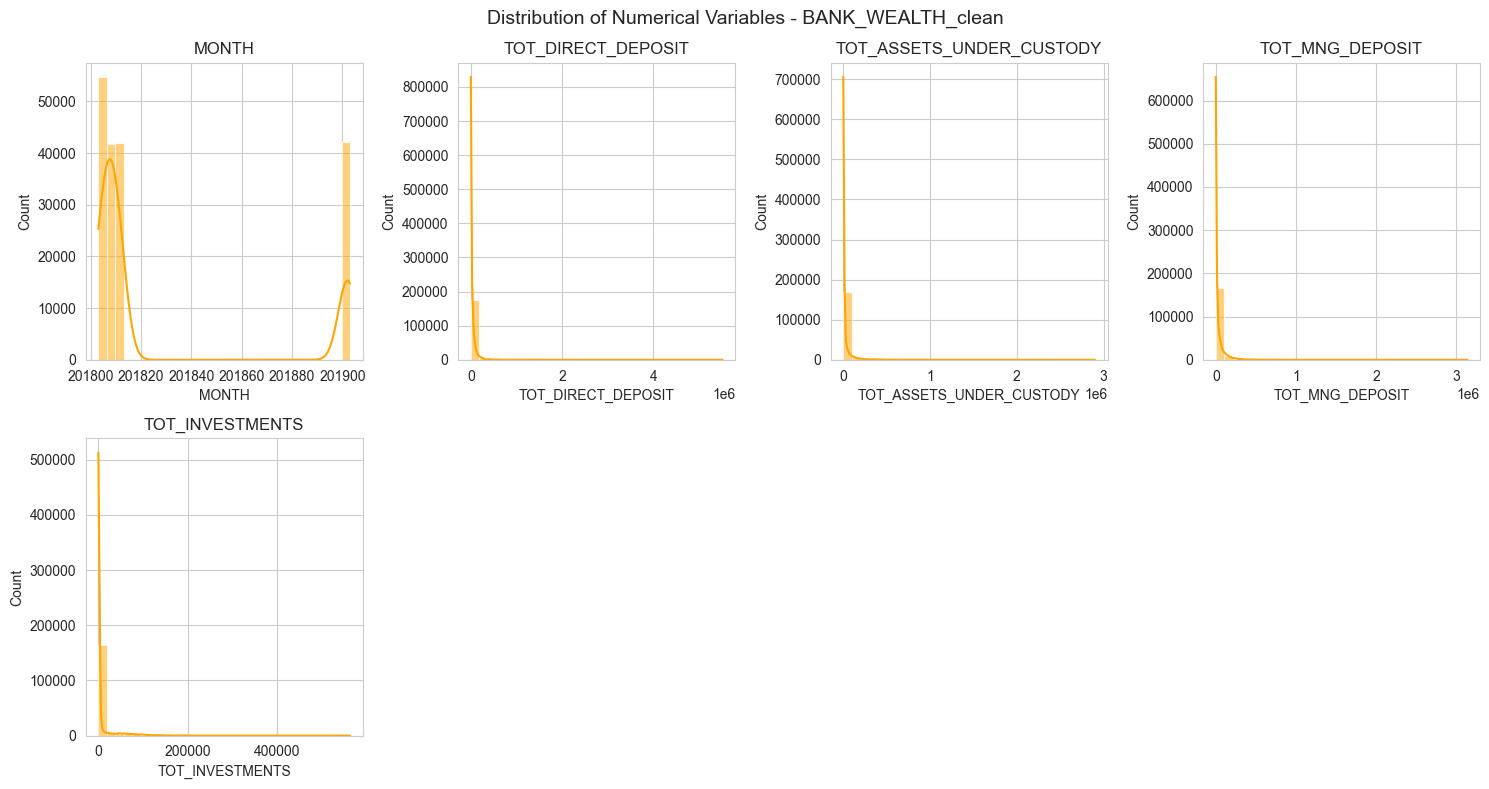

In [170]:
# Generate histograms for each dataset
for name, df in datasets.items():
    num_cols = df.select_dtypes(include=['number'])

    if not num_cols.empty:
        num_features = len(num_cols.columns)

        # Adjust figure size based on number of features
        cols = 4
        rows = int(np.ceil(num_features / cols))

        fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
        axes = axes.flatten()  # Flatten to 1D array for easy iteration

        for i, col in enumerate(num_cols.columns):
            sns.histplot(df[col], bins=30, kde=True, ax=axes[i], color="orange")
            axes[i].set_title(col)

        # Remove empty subplots if any
        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(f"Distribution of Numerical Variables - {name}", fontsize=14)
        plt.tight_layout()
        plt.show()
    else:
        print(f" No numerical columns available for histograms in {name}")

## Customers Dataset – Demographic Analysis

This section focuses on analyzing **key demographic attributes** of the bank’s customer base.

### Age Distribution
- The `DATE_OF_BIRTH` column is converted to **age in years**.
- A histogram with KDE shows the **distribution of customer ages**.
- Useful for identifying age segments such as young adults, middle-aged, seniors.

### Gender Distribution
- A bar chart displays the **count of customers by gender**.
- Helps assess **gender balance** across the dataset.

### Regional Distribution
- A horizontal bar plot visualizes **number of customers by region**.
- Identifies **regional concentration** of clients, useful for market segmentation.

These demographic patterns are essential for **targeted marketing** and **customer profiling** in financial services.

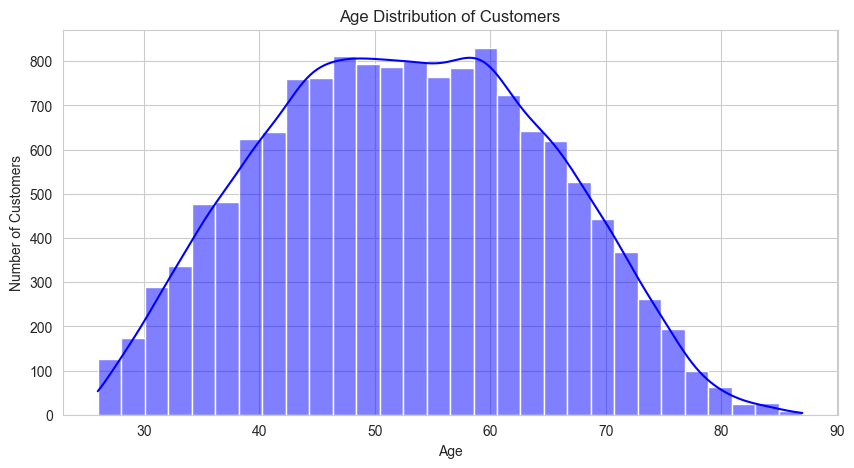

C:\Users\hp\AppData\Local\Temp\ipykernel_12852\3748316254.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_client["GENDER"], palette="viridis")


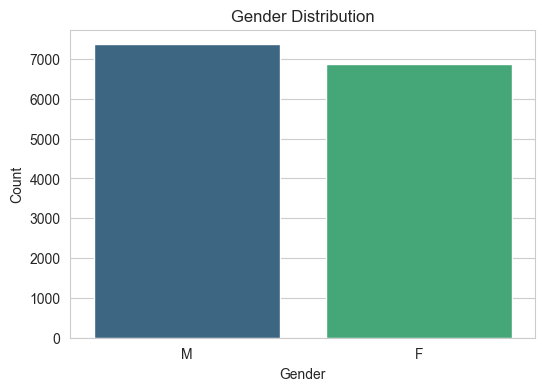

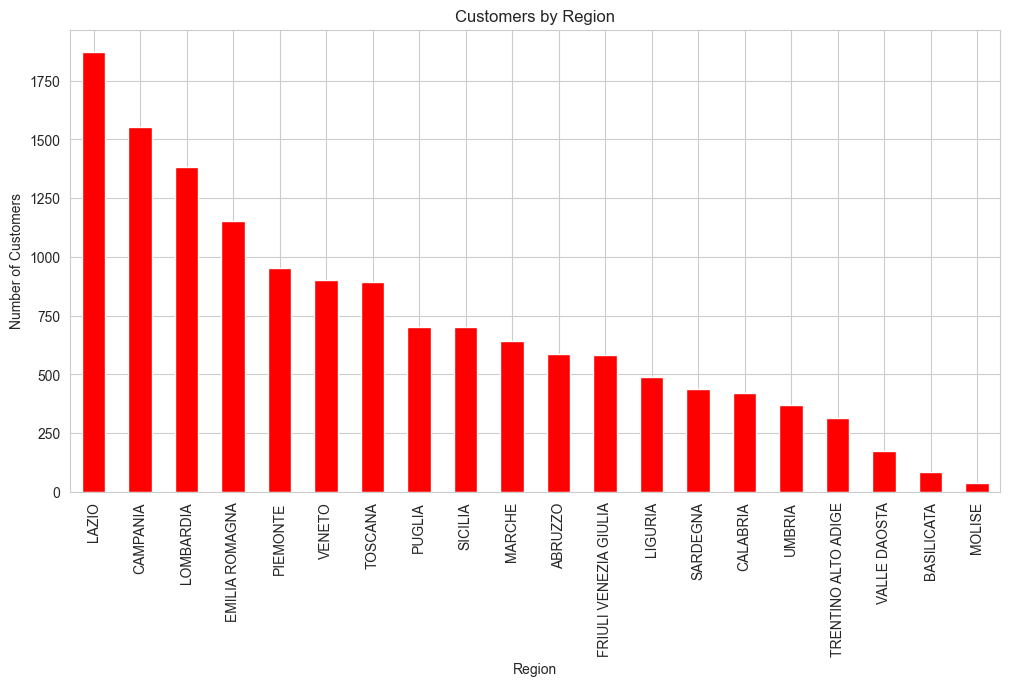

In [171]:
# Convert birth date to datetime and calculate age
df_client["DATE_OF_BIRTH"] = pd.to_datetime(df_client["DATE_OF_BIRTH"])
df_client["AGE"] = (pd.to_datetime("today") - df_client["DATE_OF_BIRTH"]).dt.days // 365

# Plotting age distribution
plt.figure(figsize=(10,5))
sns.histplot(df_client["AGE"], bins=30, kde=True, color="blue")
plt.title("Age Distribution of Customers")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.show()

# Gender distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df_client["GENDER"], palette="viridis")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

# Regional distribution
plt.figure(figsize=(12,6))
df_client["REGION"].value_counts().plot(kind="bar", color="red")
plt.title("Customers by Region")
plt.xlabel("Region")
plt.ylabel("Number of Customers")
plt.xticks(rotation=90)
plt.show()

## Banking Products – Usage Analysis

This section explores which **banking products** are most commonly owned by customers.

### What’s Being Analyzed?
- The **total count** of each product across all customers and time periods  
- Focus on identifying the **most frequently held products**

### Visualization
- A **bar chart** ranks products by total ownership count
- Useful to spot **core banking services** vs. niche offerings

This insight helps prioritize products for:
- Targeted cross-selling
- Marketing focus
- Resource allocation

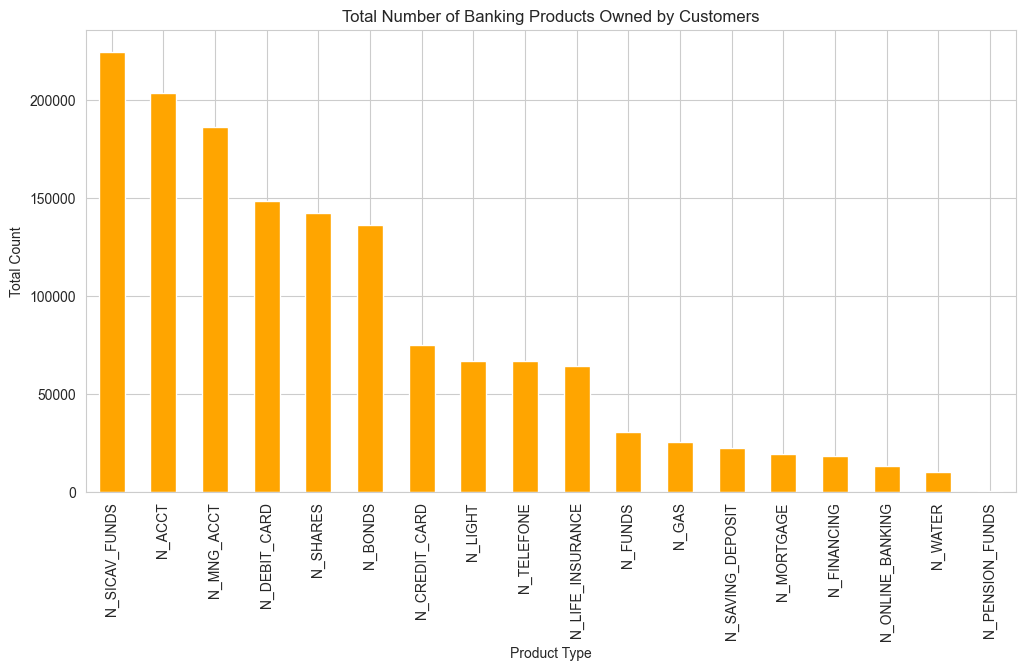

In [172]:
# Summing up all product columns
products_cols = df_products.columns[2:]  # Exclude CUSTOMER_ID and MONTH
product_totals = df_products[products_cols].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
product_totals.plot(kind="bar", color="orange")
plt.title("Total Number of Banking Products Owned by Customers")
plt.xlabel("Product Type")
plt.ylabel("Total Count")
plt.xticks(rotation=90)
plt.show()

## Bank Transfers – Transaction & Type Analysis

This section examines how customers interact with the bank through **credit** and **debit transactions**, and the **types of transfers** they perform.

### Transaction Amounts
- **Boxplots** visualize the distribution of:
  - **Credit amounts** (`AM_CREDIT`)
  - **Debit amounts** (`AM_DEBIT`)
- Useful for spotting:
  - Outliers
  - Differences in transaction behavior

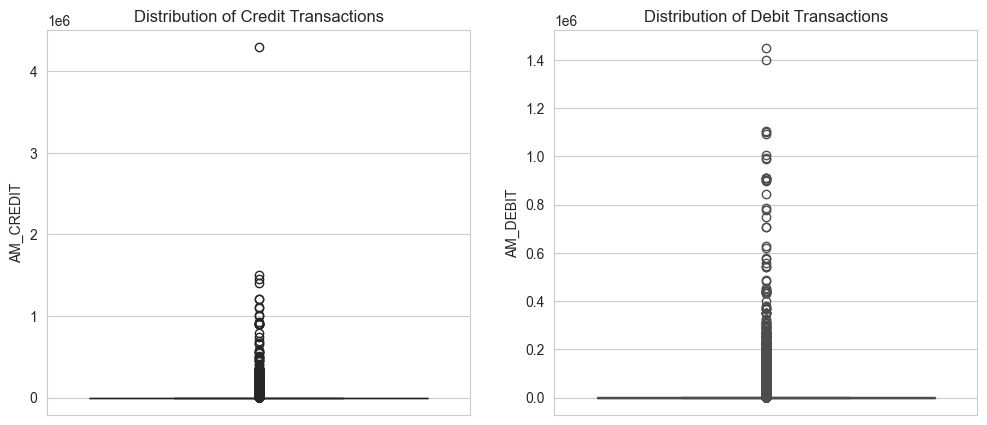

In [173]:
# Credit and debit distribution
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(y=df_transfers["AM_CREDIT"], ax=axes[0], color="green")
axes[0].set_title("Distribution of Credit Transactions")
sns.boxplot(y=df_transfers["AM_DEBIT"], ax=axes[1], color="red")
axes[1].set_title("Distribution of Debit Transactions")
plt.show()

## Violin Plot of Credit and Debit Transactions (Log Scale)

This visualization provides a **detailed view of transaction distributions**, using violin plots to combine boxplot-like summaries with kernel density estimation.

### Why Violin Plots?
- Show both the **summary statistics** and the **full distribution** of values
- Reveal **multi-modality** (multiple peaks) or **asymmetry** in the data
- More informative than boxplots when data are not normally distributed

### Why Log Scale?
- Transaction amounts can be **heavily skewed** due to outliers
- Applying `Log(1 + Amount)`:
  - Avoids log(0) errors
  - **Compresses large values**
  - Makes **extreme outliers less visually dominant**

Helps compare the spread and density of credit vs. debit amounts more clearly, especially for **high-variance financial data**.

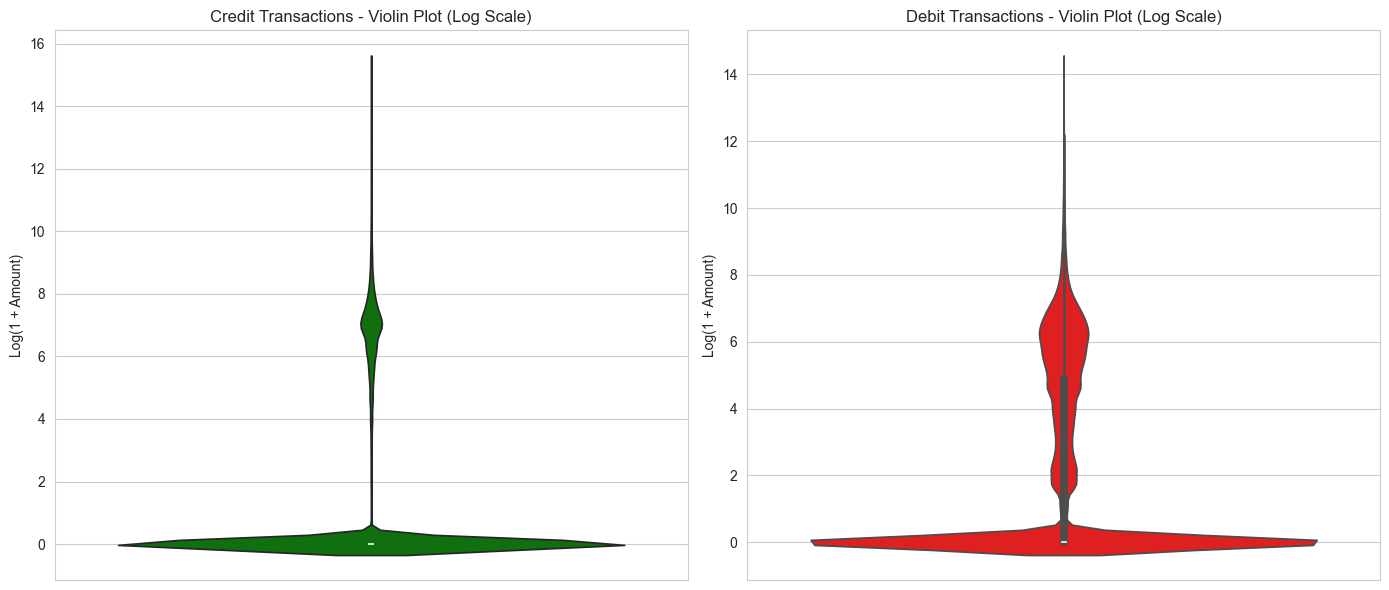

In [174]:
# Violin plots for better distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.violinplot(y=np.log1p(df_transfers["AM_CREDIT"]), ax=axes[0], color="green")
axes[0].set_title("Credit Transactions - Violin Plot (Log Scale)")
axes[0].set_ylabel("Log(1 + Amount)") # Log(1 + Amount) prevents log(0) issues --> The logarithmic scale compresses large values, making extreme outliers less dominant.

sns.violinplot(y=np.log1p(df_transfers["AM_DEBIT"]), ax=axes[1], color="red")
axes[1].set_title("Debit Transactions - Violin Plot (Log Scale)")
axes[1].set_ylabel("Log(1 + Amount)")

plt.tight_layout()
plt.show()


# METRICS:

# 1. Income Stability Index (ISI) — Concept & Business Relevance

### What is ISI?

The **Income Stability Index (ISI)** measures how consistent a customer's income is over time — in this case, across the last 12 months of direct deposits. It tells us not just how much someone earns, but **how predictable** their earnings are.

ISI is built using direct deposit data (e.g. salary, pension), which gives a clean and reliable picture of recurring income streams. We exclude irrelevant micro-transactions to focus only on meaningful income behavior.

### ISI Calculation Steps:
1. Select the last **12 months** of data (`MONTH` column)
2. Aggregate **monthly direct deposits** per customer
3. Filter out **micro-transactions** (< 10€)
4. Calculate:
   - `AVG_MONTHLY_INCOME`
   - `INCOME_STD_DEV` (volatility)
   - `ISI = AVG / STD`
5. Retain only customers with **at least 10 valid months** of data

### How to Interpret ISI

| ISI Value      | Interpretation                         |
|----------------|-----------------------------------------|
| > 10           | Very stable income                      |
| 5 – 10         | Moderately stable                       |
| 1 – 5          | Unstable                                |
| < 1            | Highly volatile income                  |
| NaN or 0       | Not enough variation / inactive client  |


### Why ISI Is Useful for Propensity Scoring

When building **propensity models** (e.g. likelihood to accept a loan, invest, churn, upgrade services), ISI adds **contextual depth** to pure income figures:

- Two clients may earn the same total amount in a year — but one earns it steadily, the other sporadically.
- Propensity to buy a financial product is often higher among customers with **stable income**, even at lower income levels.
- ISI helps the model understand **income quality**, not just quantity.

By integrating ISI, we make our propensity models smarter and more behaviorally aware.

### Why ISI Matters for Us

From a **business perspective**, ISI supports:

- **Customer segmentation**: Identify stable vs volatile earners to personalize offerings.
- **Risk minimization**: Stable-income customers are more reliable for credit products.
- **Upsell targeting**: Clients with high ISI may be more receptive to wealth or investment products.
- **Early warnings**: Drops in ISI over time may signal upcoming disengagement or financial stress.

In [175]:
# Make sure the 'MONTH' column is in integer format (YYYYMM)
df_wealth["MONTH"] = df_wealth["MONTH"].astype(int)

# Select the last 12 months available in the dataset
recent_months = sorted(df_wealth["MONTH"].unique())[-12:]

# Filter the data to only include the last 12 months
recent_wealth = df_wealth[df_wealth["MONTH"].isin(recent_months)]

# Aggregate the monthly direct deposit for each customer
# This gives us one total value per month, per customer
monthly_income = (
    recent_wealth
    .groupby(["CUSTOMER_ID", "MONTH"])["TOT_DIRECT_DEPOSIT"]
    .sum()
    .reset_index()
)

# Clean the data by removing only micro-deposits (<10€)
monthly_income_filtered = monthly_income[
    monthly_income["TOT_DIRECT_DEPOSIT"] >= 10
]

# Group by customer and calculate:
# - mean monthly income
# - standard deviation (income volatility)
# - count of valid months
isi_df = (
    monthly_income_filtered
    .groupby("CUSTOMER_ID")["TOT_DIRECT_DEPOSIT"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

# Keep only customers with at least 10 valid months of data
isi_df = isi_df[isi_df["count"] >= 10]

# Rename columns for clarity
isi_df.columns = ["CUSTOMER_ID", "AVG_MONTHLY_INCOME", "INCOME_STD_DEV", "MONTHS_COUNT"]

# Calculate the ISI (Income Stability Index)
# ISI = Average Income / Standard Deviation
# If std is 0 (perfect stability), we avoid division by zero
isi_df["ISI"] = isi_df.apply(
    lambda row: row["AVG_MONTHLY_INCOME"] / row["INCOME_STD_DEV"]
    if row["INCOME_STD_DEV"] != 0 else np.nan,
    axis=1
)

# Show top rows for review
print(isi_df.head())

  CUSTOMER_ID  AVG_MONTHLY_INCOME  INCOME_STD_DEV  MONTHS_COUNT        ISI
0  AA00263211          197.916667      126.420265            12   1.565545
1  AA00309049         4159.166667     2305.444892            12   1.804062
2  AA00313547        40754.166667     2146.878192            12  18.982990
3  AA00349160        68815.166667     7142.619151            12   9.634444
4  AA00355641         7450.083333      966.177516            12   7.710885


# 2. Average Transaction Value (ATV)

*Definition:*  
The *Average Transaction Value (ATV)* is the total amount of debit spending divided by the total number of debit transactions. It reflects how much, on average, a customer spends per transaction.

**ATV = Total Debit Amount / Number of Debit Transactions**

### Why Is This Metric Useful?

*Behavioral Insight:*  
ATV helps you understand *customer spending behavior* — whether they tend to make frequent small purchases or fewer large ones. It's a powerful signal of customer lifestyle, financial health, and spending habits.

### Role in Propensity Scoring

In *propensity modeling*, the goal is to predict the likelihood that a customer will adopt or purchase a product (e.g., credit card).  
ATV can serve as a *behavioral feature* in your model:

- Customers with *high ATV* may be more inclined to adopt *premium products*, loans, or credit facilities.
- Customers with *low but frequent transactions* may be more receptive to *daily banking tools*, like mobile payments or debit cards.
- A *sudden change in ATV* might indicate a *lifestyle or income shift*, useful for product targeting.

In short, ATV captures a *quantitative dimension of customer intent* — making it a valuable variable in any well-rounded propensity score model.

0    201803.0
1    201803.0
2    201803.0
3    201803.0
4    201803.0
Name: MONTH, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_12852\4089379928.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="YEAR_MONTH", data=df_transfers, palette="viridis")


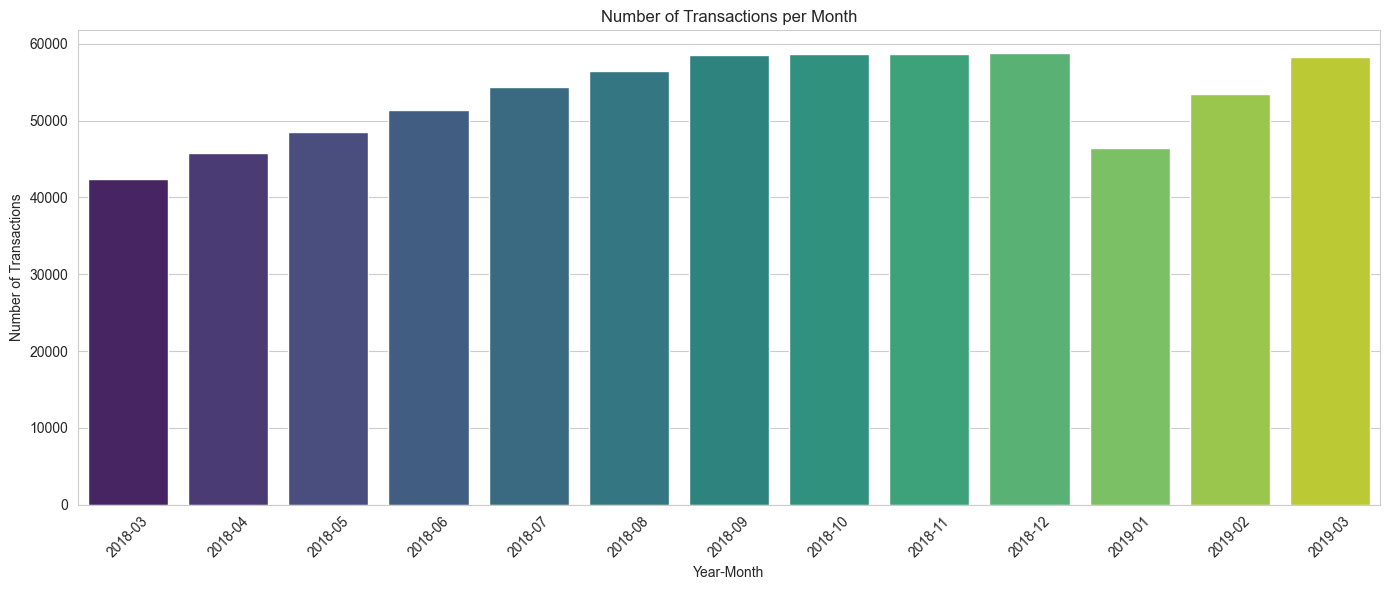

,CUSTOMER_ID,YEAR_MONTH,AM_DEBIT,NUM_DEBIT,ATV
0,AA00309049,2019-01,761.51,11.0,69.228182
1,AA00309049,2019-02,422.37,3.0,140.790000
2,AA00309049,2019-03,691.94,6.0,115.323333
3,AA00313547,2019-01,5441.45,35.0,155.470000
4,AA00313547,2019-02,7510.16,44.0,170.685455


In [176]:
# Print first few raw MONTH values
print(df_transfers["MONTH"].head())

# 1: Convert MONTH from float to int to remove ".0"
df_transfers["MONTH"] = df_transfers["MONTH"].astype(float).astype(int)

# 2: Convert to datetime using proper format (YYYYMM)
df_transfers["MONTH"] = pd.to_datetime(df_transfers["MONTH"].astype(str), format="%Y%m")

# 3: Create a new column with "Year-Month" as string (e.g., "2023-03")
df_transfers["YEAR_MONTH"] = df_transfers["MONTH"].dt.to_period("M").astype(str)

# 4: Filter for valid debit transactions (amount > 0 and number of transactions > 0)
valid_debits = df_transfers[(df_transfers["AM_DEBIT"] > 0) & (df_transfers["NUM_DEBIT"] > 0)]

# 5: Group by CUSTOMER_ID and YEAR_MONTH
df_grouped = valid_debits.groupby(['CUSTOMER_ID', 'YEAR_MONTH']).agg({
    'AM_DEBIT': 'sum',
    'NUM_DEBIT': 'sum'
}).reset_index()

# 6: Calculate Average Transaction Value (ATV)
df_grouped['ATV'] = df_grouped['AM_DEBIT'] / df_grouped['NUM_DEBIT']

# 7: Fill any remaining NaNs with 0
df_grouped['ATV'] = df_grouped['ATV'].fillna(0)

# 8: Plot the distribution of transactions per month
plt.figure(figsize=(14, 6))
sns.countplot(x="YEAR_MONTH", data=df_transfers, palette="viridis")
plt.title("Number of Transactions per Month")
plt.xlabel("Year-Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 9: Preview the grouped result
df_grouped.head()



# MERGING THE DATASETS:

# Building the Final Dataset

In this section, we consolidate information from the four distinct banking datasets (**Clients**, **Transfers**, **Products**, and **Wealth**) to construct a unified, customer-level dataset suitable for modeling. This process involves data cleaning, feature engineering, aggregation, and normalization, resulting in a structured foundation for predictive analytics.

### 1: Enriching Client Profiles

We begin with the `df_client` dataset containing demographic information:

- **Age** is derived from `DATE_OF_BIRTH` as the difference between the current year and the birth year.
- **Seniority** (i.e., customer tenure) is computed from the `REGISTRATION_DATE`, indicating how long the client has been with the bank.
- **Gender** is encoded in binary format (`M` → `1`, `F` → `0`) to make it suitable for numerical analysis.

### 2: Summarizing Financial Activity (Transfers)

The `df_transfers` dataset holds monthly records of debit and credit operations. Key steps include:

- Converting the `MONTH` column to datetime and extracting the `YEAR`.
- Grouping by `CUSTOMER_ID` and `YEAR`, and computing aggregated statistics:
  - For **monetary values** (`AM_DEBIT`, `AM_CREDIT`): `sum`, `mean`, `max`, `min`
  - For **transaction counts** (`NUM_DEBIT`, `NUM_CREDIT`): `sum`, `mean`, `max`
- The result is merged with the client dataset using a **left join**, ensuring no customer is lost; missing values are filled with zero.

### 3: Aggregating Product Usage

Using the `df_products` dataset, we summarize each customer's engagement with banking products:

- For most product types (e.g., accounts, insurance, credit/debit cards), both **sum** and **mean** values are computed.
- Utility payments (`WATER`, `LIGHT`, `GAS`, `TELEFONE`) are aggregated using only the total count.

This results in a comprehensive profile of each client's **product adoption and financial footprint**.

### 4: Profiling Customer Wealth

The `df_wealth` dataset is aggregated to capture clients' investment and deposit behaviors:

- For each customer, we compute the `sum`, `mean`, and `max` across key financial dimensions:
  - **Direct Deposits**
  - **Assets Under Custody**
  - **Managed Deposits**
  - **Total Investments**

This information reflects both the volume and volatility of a customer's wealth and investment activity.

### 5: Advanced Feature Engineering

After merging all datasets, we derive additional behavioral and stability indicators:

- **ATV (Average Transaction Value)**: Calculated as total debit amount divided by total number of debit transactions. Division by zero is safely handled.
- **ISI (Income Stability Index)**:
  - Defined as the mean divided by the standard deviation of `TOT_DIRECT_DEPOSIT`, with adjustments to avoid division by zero.
  - A low ISI indicates erratic or unstable income behavior.

### 6: Feature Scaling

To standardize key continuous features for modeling, we apply **Min-Max Scaling** to:

- `TOT_DIRECT_DEPOSIT_mean` → `SCALED_DEPOSIT`
- `ISI` → `SCALED_ISI`
- `TOT_ASSETS_UNDER_CUSTODY_sum` → `SCALED_ASSETS`
- `ATV` → `SCALED_ATV`

This brings all values into a `[0, 1]` range and ensures comparability across features with different units or magnitudes.

### Final Output

The final dataset, `full_data`, is a **clean, structured, and feature-rich customer-level table** ready for downstream tasks like propensity modeling. It combines demographic, transactional, behavioral, and financial insights, with all missing values handled and non-essential columns dropped for clarity and efficiency.


In [ ]:
# Convert birth date to datetime and compute age
df_client["DATE_OF_BIRTH"] = pd.to_datetime(df_client["DATE_OF_BIRTH"])
df_client["AGE"] = datetime.now().year - df_client["DATE_OF_BIRTH"].dt.year



# Process registration date and compute seniority
df_client["REGISTRATION_DATE"] = pd.to_datetime(df_client["REGISTRATION_DATE"])
df_client["REGISTRATION_YEAR"] = df_client["REGISTRATION_DATE"].dt.year
df_client["SENIORITY"] = datetime.now().year - df_client["REGISTRATION_YEAR"]

# Convert gender to binary format (M = 1, F = 0)
df_client["GENDER"] = df_client["GENDER"].map({'M': 1, 'F': 0})

In [178]:
# Convert MONTH to datetime and extract YEAR (MUST be before groupby)
df_transfers["MONTH"] = pd.to_datetime(df_transfers["MONTH"])
df_transfers["YEAR"] = df_transfers["MONTH"].dt.year

# Aggregate per CUSTOMER_ID per YEAR
transfer_agg = df_transfers.groupby(["CUSTOMER_ID", "YEAR"]).agg({
    "AM_DEBIT": ["sum", "mean", "max", "min"],
    "AM_CREDIT": ["sum", "mean", "max", "min"],
    "NUM_DEBIT": ["sum", "mean", "max"],
    "NUM_CREDIT": ["sum", "mean", "max"]
}).reset_index()

# Flatten multi-level column names
transfer_agg.columns = ['CUSTOMER_ID', 'YEAR'] + [f"{col[0]}_{col[1]}" for col in transfer_agg.columns[2:]]

# Keep only the most recent year of activity per customer
latest_transfer = transfer_agg.sort_values("YEAR").groupby("CUSTOMER_ID").tail(1).reset_index(drop=True)

# MERGE CLIENT + TRANSFER (keep all clients) 
client_with_transfer = df_client.merge(latest_transfer, on="CUSTOMER_ID", how="left")
client_with_transfer.fillna(0, inplace=True)

# Done 
print("Final dataset shape:", client_with_transfer.shape)
print("Unique clients:", client_with_transfer["CUSTOMER_ID"].nunique())


Final dataset shape: (14241, 23)
Unique clients: 14241


In [179]:
print(df_client.columns)
print(df_products.columns)
print(df_transfers.columns)
print(df_wealth.columns)


Index(['CUSTOMER_ID', 'REGISTRATION_DATE', 'DATE_OF_BIRTH', 'REGION', 'GENDER',
       'AGE', 'REGISTRATION_YEAR', 'SENIORITY'],
      dtype='object')
Index(['CUSTOMER_ID', 'MONTH', 'N_ACCT', 'N_MNG_ACCT', 'N_SAVING_DEPOSIT',
       'N_BONDS', 'N_SHARES', 'N_FUNDS', 'N_LIFE_INSURANCE', 'N_MORTGAGE',
       'N_FINANCING', 'N_WATER', 'N_LIGHT', 'N_GAS', 'N_TELEFONE',
       'N_DEBIT_CARD', 'N_ONLINE_BANKING', 'N_CREDIT_CARD', 'N_SICAV_FUNDS',
       'N_PENSION_FUNDS'],
      dtype='object')
Index(['MONTH', 'TRANSFER_TYPE_DES', 'CUSTOMER_ID', 'AM_CREDIT', 'AM_DEBIT',
       'NUM_CREDIT', 'NUM_DEBIT', 'YEAR_MONTH', 'YEAR'],
      dtype='object')
Index(['CUSTOMER_ID', 'MONTH', 'TOT_DIRECT_DEPOSIT',
       'TOT_ASSETS_UNDER_CUSTODY', 'TOT_MNG_DEPOSIT', 'TOT_INVESTMENTS'],
      dtype='object')


In [180]:
# Aggregate monthly product usage per customer
products_agg = df_products.groupby("CUSTOMER_ID").agg({
    "N_ACCT": ["sum", "mean"],
    "N_MNG_ACCT": ["sum", "mean"],
    "N_SAVING_DEPOSIT": ["sum", "mean"],
    "N_BONDS": ["sum", "mean"],
    "N_SHARES": ["sum", "mean"],
    "N_FUNDS": ["sum", "mean"],
    "N_LIFE_INSURANCE": ["sum", "mean"],
    "N_MORTGAGE": ["sum", "mean"],
    "N_FINANCING": ["sum", "mean"],
    "N_CREDIT_CARD": ["sum", "mean"],
    "N_DEBIT_CARD": ["sum", "mean"],
    "N_ONLINE_BANKING": ["sum", "mean"],
    "N_SICAV_FUNDS": ["sum", "mean"],
    "N_PENSION_FUNDS": ["sum", "mean"],
    "N_WATER": ["sum"],
    "N_LIGHT": ["sum"],
    "N_GAS": ["sum"],
    "N_TELEFONE": ["sum"]
}).reset_index()

# Flatten multi-level column names
products_agg.columns = ['CUSTOMER_ID'] + [f"{col[0]}_{col[1]}" for col in products_agg.columns[1:]]


In [181]:
# Aggregate monthly wealth data per customer
wealth_agg = df_wealth.groupby("CUSTOMER_ID").agg({
    "TOT_DIRECT_DEPOSIT": ["sum", "mean", "max"],
    "TOT_ASSETS_UNDER_CUSTODY": ["sum", "mean", "max"],
    "TOT_MNG_DEPOSIT": ["sum", "mean", "max"],
    "TOT_INVESTMENTS": ["sum", "mean", "max"]
}).reset_index()

# Flatten column names
wealth_agg.columns = ['CUSTOMER_ID'] + [f"{col[0]}_{col[1]}" for col in wealth_agg.columns[1:]]


In [182]:
# Merge client with all features
full_data = df_client.merge(latest_transfer, on="CUSTOMER_ID", how="left")
full_data = full_data.merge(products_agg, on="CUSTOMER_ID", how="left")
full_data = full_data.merge(wealth_agg, on="CUSTOMER_ID", how="left")

# Fill missing values with 0
full_data.fillna(0, inplace=True)

print("Final dataset shape:", full_data.shape)
print("Unique customers:", full_data["CUSTOMER_ID"].nunique())


Final dataset shape: (14241, 67)
Unique customers: 14241


In [183]:
# Columns to drop (example)
columns_to_drop = ["REGISTRATION_DATE","REGISTRATION_YEAR", "DATE_OF_BIRTH", "YEAR"]

# Drop them
full_data.drop(columns=columns_to_drop, inplace=True)

In [184]:
full_data.columns
full_data.shape

(14241, 63)

In [185]:
# Compute ATV safely (avoid division by zero)
full_data["ATV"] = (
    (full_data["AM_DEBIT_sum"] ) /
   (full_data["NUM_DEBIT_sum"]).replace(0, 1)  # prevent division by zero
)

print(full_data[["CUSTOMER_ID", "ATV"]])

      CUSTOMER_ID    ATV
0      DF00261884    0.0
1      IQ00262656    0.0
2      QA00262675  800.0
3      IX00262687    0.0
4      AA00263211    0.0
...           ...    ...
14236  NN01129128    0.0
14237  WW01129264    0.0
14238  HR01129307    0.0
14239  PA01129365    0.0
14240  BI01129496    0.0

[14241 rows x 2 columns]


In [186]:
# 1: Compute std deviation of TOT_DIRECT_DEPOSIT by month per customer
direct_deposit_std = df_wealth.groupby("CUSTOMER_ID")["TOT_DIRECT_DEPOSIT"].std().reset_index()
direct_deposit_std.columns = ["CUSTOMER_ID", "TOT_DIRECT_DEPOSIT_STD"]

# 2: Merge std with existing mean deposit in full_data
isi_data = full_data[["CUSTOMER_ID", "TOT_DIRECT_DEPOSIT_mean"]].merge(
    direct_deposit_std, on="CUSTOMER_ID", how="left"
)

# 3: Compute ISI = mean / std (replace 0 std to avoid division by zero)
isi_data["ISI"] = isi_data["TOT_DIRECT_DEPOSIT_mean"] / isi_data["TOT_DIRECT_DEPOSIT_STD"].replace(0, 1)

# 4: Merge ISI back into the full dataset
# Drop previous ISI if it exists
if "ISI" in full_data.columns:
    full_data.drop(columns=["ISI"], inplace=True)

full_data = full_data.merge(isi_data[["CUSTOMER_ID", "ISI"]], on="CUSTOMER_ID", how="left")

# 5: Fill missing ISI values (e.g., inactive clients)
full_data["ISI"] = full_data["ISI"].fillna(0)


In [187]:
full_data["ISI"].describe()

count    14241.000000
mean        23.886685
std        678.077706
min          0.000000
25%          1.172591
50%          2.552383
75%          6.468604
max      59500.000000
Name: ISI, dtype: float64

In [188]:
# Normalize input features
scaler = MinMaxScaler()
full_data[["SCALED_DEPOSIT", "SCALED_ISI", "SCALED_ASSETS", "SCALED_ATV"]] = scaler.fit_transform(
    full_data[[
        "TOT_DIRECT_DEPOSIT_mean", 
        "ISI", 
        "TOT_ASSETS_UNDER_CUSTODY_sum", 
        "ATV"
    ]]
)

full_data.columns

Index(['CUSTOMER_ID', 'REGION', 'GENDER', 'AGE', 'SENIORITY', 'AM_DEBIT_sum',
       'AM_DEBIT_mean', 'AM_DEBIT_max', 'AM_DEBIT_min', 'AM_CREDIT_sum',
       'AM_CREDIT_mean', 'AM_CREDIT_max', 'AM_CREDIT_min', 'NUM_DEBIT_sum',
       'NUM_DEBIT_mean', 'NUM_DEBIT_max', 'NUM_CREDIT_sum', 'NUM_CREDIT_mean',
       'NUM_CREDIT_max', 'N_ACCT_sum', 'N_ACCT_mean', 'N_MNG_ACCT_sum',
       'N_MNG_ACCT_mean', 'N_SAVING_DEPOSIT_sum', 'N_SAVING_DEPOSIT_mean',
       'N_BONDS_sum', 'N_BONDS_mean', 'N_SHARES_sum', 'N_SHARES_mean',
       'N_FUNDS_sum', 'N_FUNDS_mean', 'N_LIFE_INSURANCE_sum',
       'N_LIFE_INSURANCE_mean', 'N_MORTGAGE_sum', 'N_MORTGAGE_mean',
       'N_FINANCING_sum', 'N_FINANCING_mean', 'N_CREDIT_CARD_sum',
       'N_CREDIT_CARD_mean', 'N_DEBIT_CARD_sum', 'N_DEBIT_CARD_mean',
       'N_ONLINE_BANKING_sum', 'N_ONLINE_BANKING_mean', 'N_SICAV_FUNDS_sum',
       'N_SICAV_FUNDS_mean', 'N_PENSION_FUNDS_sum', 'N_PENSION_FUNDS_mean',
       'N_WATER_sum', 'N_LIGHT_sum', 'N_GAS_sum', 'N_TE

In [189]:
# Export the final dataset
#full_data.to_csv(r'C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\final_dataset.csv', index=False)

# PART 2:

## Loading the merged dataset

In [190]:
# Loading the dataset
url = r'C:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\data\final_dataset.csv' 
df = pd.read_csv(url, header=0, sep=',')

df.head(10)

,CUSTOMER_ID,REGION,GENDER,AGE,SENIORITY,AM_DEBIT_sum,AM_DEBIT_mean,AM_DEBIT_max,AM_DEBIT_min,AM_CREDIT_sum,...,TOT_MNG_DEPOSIT_max,TOT_INVESTMENTS_sum,TOT_INVESTMENTS_mean,TOT_INVESTMENTS_max,ATV,ISI,SCALED_DEPOSIT,SCALED_ISI,SCALED_ASSETS,SCALED_ATV
0,DF00261884,EMILIA ROMAGNA,1,38,13,0.00,0.000000,0.00,0.0,20.0,...,374294.0,0.0,0.000000,0.0,0.000000,2.473988,0.006832,0.000042,0.005573,0.000000
1,IQ00262656,SARDEGNA,1,41,8,0.00,0.000000,0.00,0.0,2000.0,...,5827.0,6682.0,514.000000,1146.0,0.000000,1.473623,0.000183,0.000025,0.000000,0.000000
2,QA00262675,CAMPANIA,0,50,17,800.00,800.000000,800.00,800.0,0.0,...,78159.0,0.0,0.000000,0.0,800.000000,11.155349,0.023301,0.000187,0.000000,0.001070
3,IX00262687,VENETO,0,55,8,0.00,0.000000,0.00,0.0,10.0,...,26387.0,34028.0,2617.538462,9997.0,0.000000,1.106605,0.001237,0.000019,0.000049,0.000000
4,AA00263211,UMBRIA,1,46,24,0.00,0.000000,0.00,0.0,200.0,...,0.0,2687.0,206.692308,500.0,0.000000,1.180547,0.000055,0.000020,0.000000,0.000000
5,FE00263328,CALABRIA,0,70,18,497987.78,99597.556000,249987.78,0.0,498000.0,...,376908.0,0.0,0.000000,0.0,165995.926667,1.663559,0.012464,0.000028,0.003432,0.222068
6,SR00263523,MOLISE,1,50,11,8379.90,1675.980000,7022.89,0.0,12000.0,...,25479.0,0.0,0.000000,0.0,1675.980000,39.461547,0.006886,0.000663,0.000000,0.002242
7,SO00263901,CALABRIA,1,42,17,0.00,0.000000,0.00,0.0,350.0,...,51273.0,0.0,0.000000,0.0,0.000000,49.749094,0.026193,0.000836,0.000579,0.000000
8,CR00264169,SARDEGNA,0,66,24,10000.00,3333.333333,10000.00,0.0,20000.0,...,0.0,0.0,0.000000,0.0,10000.000000,87.380465,0.016629,0.001469,0.000000,0.013378
9,NH00264363,CAMPANIA,0,56,16,0.00,0.000000,0.00,0.0,10.0,...,36955.0,0.0,0.000000,0.0,0.000000,26.454625,0.102482,0.000445,0.005991,0.000000


# ADDING EXTRA VARIABLES:

## 1. Ratio Features (financial behavior indicators)

To further enrich the dataset, we derive three additional **behavioral ratios** that provide insight into customers’ financial habits and preferences:

- **Credit-to-Debit Ratio** (`credit_debit_ratio`):  
  Measures the proportion of credited (inflow) amounts relative to debited (outflow) amounts.  
  A higher value suggests greater reliance on income or credit sources, while a lower value may indicate spending intensity.

- **Investment-to-Deposit Ratio** (`investment_deposit_ratio`):  
  Captures the customer's appetite for investment by comparing total investments to managed deposits.  
  Useful for identifying financially active or risk-oriented profiles.

- **Spending Activity Ratio** (`spending_activity_ratio`):  
  Represents the average number of monthly transactions (debits + credits) normalized by customer **seniority** (in months).  
  It reflects how active a customer is in using banking services over time.

A small constant (`epsilon = 1e-6`) is added to denominators to prevent division by zero and ensure numerical stability.


In [191]:
epsilon = 1e-6  # Small constant to prevent division by zero

# Ratio of total credit inflow to total debit outflow — indicates preference for credit usage
df["credit_debit_ratio"] = df["AM_CREDIT_sum"] / (df["AM_DEBIT_sum"] + epsilon)

# Ratio of total investments to total managed deposits — measures investment appetite
df["investment_deposit_ratio"] = df["TOT_INVESTMENTS_sum"] / (df["TOT_MNG_DEPOSIT_sum"] + epsilon)

# Average transaction activity per month — normalized by customer's seniority (in months)
df["spending_activity_ratio"] = (df["NUM_CREDIT_sum"] + df["NUM_DEBIT_sum"]) / (df["SENIORITY"] + epsilon)


## 2. Behavioral Dynamics Features (volatility and dispersion)

### Feature Engineering: Variability & Dispersion Indicators

This set of features captures the **fluctuation** and **volatility** of financial behaviors over time. They offer insight into the consistency—or unpredictability—of a customer’s financial flows and investment habits.

- **Debit Volatility** (`debit_volatility`):  
  Measures how much debit amounts vary, relative to their average.  
  Higher values suggest **irregular or bursty spending patterns**, while lower values indicate stable debit behavior.

- **Credit Volatility** (`credit_volatility`):  
  Analogous to debit volatility, this feature assesses variability in credited amounts.  
  It reflects **income stability or irregular inflow events**.

- **Investment Dispersion** (`investment_dispersion`):  
  Quantifies how far the maximum investment amount deviates from the mean.  
  A higher value may imply **opportunistic or non-recurring investment behavior**.

- **Managed Deposit Dispersion** (`deposit_dispersion`):  
  Captures the inconsistency in managed deposits across observed periods.  
  It highlights **fluctuations in customer saving or asset management habits**.

As with previous features, a small constant `epsilon` is added to denominators to prevent division by zero and ensure numerical robustness.


In [192]:
# Debit volatility — how much debit amounts fluctuate relative to the average
df["debit_volatility"] = (df["AM_DEBIT_max"] - df["AM_DEBIT_min"]) / (df["AM_DEBIT_mean"] + epsilon)

# Credit volatility — similar for credit transactions
df["credit_volatility"] = (df["AM_CREDIT_max"] - df["AM_CREDIT_min"]) / (df["AM_CREDIT_mean"] + epsilon)

# Investment dispersion — indicates variability of investment amounts
df["investment_dispersion"] = (df["TOT_INVESTMENTS_max"] - df["TOT_INVESTMENTS_mean"]) / (df["TOT_INVESTMENTS_mean"] + epsilon)

# Managed deposit dispersion — variability in managed deposits over time
df["deposit_dispersion"] = (df["TOT_MNG_DEPOSIT_max"] - df["TOT_MNG_DEPOSIT_mean"]) / (df["TOT_MNG_DEPOSIT_mean"] + epsilon)


# TARGET BINARIZATION:

In [193]:
df["TARGET_CREDIT_CARD"] = (df["N_CREDIT_CARD_sum"] > 0).astype(int)
df.shape

(14241, 77)

# Encoding Categorical Data & Pruning Redundant Features

In this final preprocessing step, we focus on preparing categorical variables for modeling and streamlining the feature space by removing unnecessary columns.

- **Dummy Encoding of `REGION`**:  
  The `REGION` column is transformed using **dummy encoding**, which creates a separate binary column for each unique region (e.g., `REGION_SICILIA`, `REGION_LAZIO`, etc.).  
  This allows models to capture location-based patterns without assuming any implicit order among the regions.  

- **Removing Low-Level Summary Statistics**:  
  After engineering advanced features (e.g., ratios, volatilities, dispersions), the original descriptive statistics—columns ending in `_mean`, `_max`, or `_min`—are dropped.  
  These values have been integrated into more expressive features, and keeping them would add redundancy and potential noise.

This step helps simplify the dataset, reduce feature overlap, and ensure that categorical variables are in a machine-learning-friendly format.


In [194]:
# Dummies for the categorical column REGION
df = pd.get_dummies(df, columns=["REGION"], prefix="REGION")

# Drop columns that ends with '_mean', '_max' o '_min'
columns_to_drop = [
    col for col in df.columns 
    if col.endswith('_mean') or col.endswith('_max') or col.endswith('_min')
]
df.drop(columns=columns_to_drop, inplace=True)
df.shape


(14241, 64)

# PREPARE X and Y:
### Preparing Features and Target for Modeling

In this step, we define the input features (`X`) and the prediction target (`y`) for our machine learning model.

- **Target Variable**:  
  `y` is set to `TARGET_CREDIT_CARD`, a binary flag indicating whether the customer owns a credit card.

- **Feature Matrix (`X`)**:  
  We drop variables that are:
  - **Directly derived from or identical to the target** (e.g., `N_CREDIT_CARD_sum`, `TARGET_CREDIT_CARD`)
  - **Identifiers** (`CUSTOMER_ID`) that provide no predictive power
  - **Raw versions of already scaled features** (`ISI`, `ATV`), to avoid redundancy

This step ensures that the model learns from independent signals and prevents **data leakage**, where the model might unfairly learn from variables too closely tied to the outcome.


In [195]:
# Define X and y
# Drop variables directly related to the target
drop_columns = [
    "N_CREDIT_CARD_sum",  # The raw count used to create the target
    "TARGET_CREDIT_CARD", # The target itself
    "N_CREDIT_CARD_mean",
    "CUSTOMER_ID",         # Identifier, not useful for modeling
    "ISI",            # Income Stability Index, we already have the scaled version
    "ATV",           # Average Transaction Value, we already have the scaled version
    
]

X = df.drop(columns=drop_columns, errors='ignore')
y = df["TARGET_CREDIT_CARD"]

# Check shapes
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (14241, 59)
y shape: (14241,)


# Splitting Data into TRAIN and TEST Sets

We divide the dataset into training and test sets to evaluate the model’s performance on unseen data.

A **stratified split** is used to ensure that the proportion of positive and negative classes in the target (`TARGET_CREDIT_CARD`) remains consistent across both sets.  
This is especially important when dealing with **imbalanced classification problems**, as it prevents skewed class distributions that could bias evaluation metrics.

Stratification preserves the underlying label distribution, ensuring a fairer and more reliable model validation.


In [196]:
# Stratified split to preserve class proportions
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

# Verify class distribution
print("Training set class distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\nTesting set class distribution:")
print(pd.Series(y_test).value_counts(normalize=True))

Training set class distribution:
TARGET_CREDIT_CARD
0    0.654695
1    0.345305
Name: proportion, dtype: float64

Testing set class distribution:
TARGET_CREDIT_CARD
0    0.654575
1    0.345425
Name: proportion, dtype: float64


# FEATURE SELECTION: 
## Identifying the Most Predictive Variables (Only on the Train set)

Feature selection is a fundamental step in the modeling pipeline. It allows us to:
- Improve model **interpretability**
- Reduce **overfitting**
- Lower **computational cost**
- Eliminate irrelevant or redundant variables

Here, we compare three complementary techniques to identify the most relevant features for predicting credit card ownership.

### 1. **SelectKBest with ANOVA F-test**

- **What it does**:  
  SelectKBest ranks features based on their **individual, univariate relationship** with the target using the **ANOVA F-statistic**.
  
- **How it works**:  
  For each feature, the method tests whether the **mean value** differs significantly between the target classes.  
  Higher scores indicate stronger **discriminative power**.

- **Why it matters**:  
  This approach is fast and intuitive, providing a first-pass filter to rank features by statistical relevance.

- **Interpretation**:  
  Features with the highest F-scores are most associated with class separation. However, it does **not consider interactions** between features.


### 2. **Lasso (Logistic Regression with L1 Regularization)**

- **What it does**:  
  Lasso introduces a **penalty on the absolute value of coefficients**, shrinking less important ones to zero.

- **How it works**:  
  It fits a logistic regression model with L1 regularization, which performs **embedded feature selection** by eliminating irrelevant variables during model training.

- **Why it matters**:  
  Lasso is useful when we suspect that **only a subset of features truly matter**, and we want a **sparse, interpretable model**.

- **Interpretation**:  
  Non-zero coefficients indicate the most informative features. Coefficients shrunk to zero are considered irrelevant in predicting the target.

Unlike SelectKBest, Lasso takes into account **multivariate interactions** and **correlations** between features.


### 3. **Random Forest Feature Importance**

- **What it does**:  
  Uses a **tree-based ensemble model** to evaluate the predictive power of each feature.

- **How it works**:  
  Features are ranked by their **contribution to reducing impurity** across all decision trees (i.e., how much they help split the data effectively).

- **Why it matters**:  
  This method captures **non-linear relationships** and **feature interactions**, and works well even when the data is not standardized.

- **Interpretation**:  
  Higher importance scores reflect a greater impact on prediction. Unlike Lasso or SelectKBest, this technique is **model-driven**, not purely statistical.


### Why Use Multiple Methods?

Each method provides a different perspective:
- **SelectKBest** → Univariate, fast, statistically intuitive
- **Lasso** → Embedded, interpretable, multivariate
- **Random Forest** → Non-linear, interaction-aware, model-based

Using all three allows us to cross-validate and **triangulate the most robust predictors**, leading to a better understanding of feature relevance and a more solid foundation for modeling.



In [197]:
# 1. SelectKBest (ANOVA F-test)
skb = SelectKBest(score_func=f_classif, k='all')
skb.fit(X_train, y_train)

skb_scores = pd.Series(skb.scores_, index=X_train.columns)
print("\nTop features by SelectKBest (ANOVA F-test):")
print(skb_scores.sort_values(ascending=False).head(10))

# Reducing the train set with the top N (e.g. 10) features
top_skb_features = skb_scores.sort_values(ascending=False).head(10).index.tolist()
X_train_skb = X_train[top_skb_features]

# 2. Lasso (Logistic Regression with L1)
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
)
lasso_pipeline.fit(X_train, y_train)

lasso_coef = pd.Series(
    lasso_pipeline.named_steps['logisticregression'].coef_[0],
    index=X_train.columns
)
print("\nTop features by Lasso (non-zero coefficients):")
print(lasso_coef[lasso_coef != 0].sort_values(key=abs, ascending=False).head(10))

lasso_features = lasso_coef[lasso_coef != 0].index.tolist()
X_train_lasso = X_train[lasso_features]

# 3. RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print("\nTop features by RandomForestClassifier:")
print(rf_importances.sort_values(ascending=False).head(10))

top_rf_features = rf_importances.sort_values(ascending=False).head(10).index.tolist()
X_train_rf = X_train[top_rf_features]



Top features by SelectKBest (ANOVA F-test):
N_DEBIT_CARD_sum        613.725684
N_ACCT_sum              318.359687
N_TELEFONE_sum          309.832983
N_LIGHT_sum             256.778550
N_ONLINE_BANKING_sum    241.514944
N_MNG_ACCT_sum          188.196525
N_GAS_sum               114.777992
TOT_INVESTMENTS_sum      80.015174
N_BONDS_sum              71.492200
N_SHARES_sum             61.307683
dtype: float64

Top features by Lasso (non-zero coefficients):
SCALED_ISI               -6.489204
TOT_DIRECT_DEPOSIT_sum   -0.879799
SCALED_DEPOSIT            0.867043
N_DEBIT_CARD_sum          0.333955
N_ACCT_sum                0.278621
N_ONLINE_BANKING_sum      0.229897
N_BONDS_sum              -0.211992
REGION_SICILIA           -0.197146
N_TELEFONE_sum            0.192657
TOT_INVESTMENTS_sum       0.187042
dtype: float64

Top features by RandomForestClassifier:
SCALED_ISI                 0.053505
TOT_DIRECT_DEPOSIT_sum     0.049314
SCALED_DEPOSIT             0.048399
N_DEBIT_CARD_sum           0

# Cross-Method Comparison of Feature Selection Results

After computing feature importance using three different methods—**SelectKBest (ANOVA F-test)**, **Lasso Regression**, and **Random Forest**—we now compare their outputs to identify the most consistently selected features.

### Selection Criteria

Each method applies its own logic and scale, so we define unified selection thresholds to standardize the comparison:

- **SelectKBest** → Features in the **top 25%** of F-scores  
- **Lasso** → Features with **non-zero** model coefficients  
- **Random Forest** → Features in the **top 25%** of importance scores

These thresholds allow us to treat selections as binary decisions (selected or not) across methods.


### Method Agreement Scoring

For every feature, we calculate how many of the three methods selected it. This results in a **consensus score** (`Total_Methods_Selected`) ranging from 0 (not selected by any method) to 3 (selected by all).

This score highlights features that are **robustly important**, independent of the specific selection technique.


### Visualizing Agreement

We generate a heatmap showing the top 30 features with the highest consensus scores. The heatmap provides a quick visual summary of:

- Which features are **repeatedly selected**
- Which methods tend to agree
- Which features are **method-specific**

Features selected by **multiple independent methods** are more likely to be genuinely predictive and less likely to result from statistical noise or overfitting.

This multi-method comparison offers a **data-driven foundation** for final feature selection before modeling.


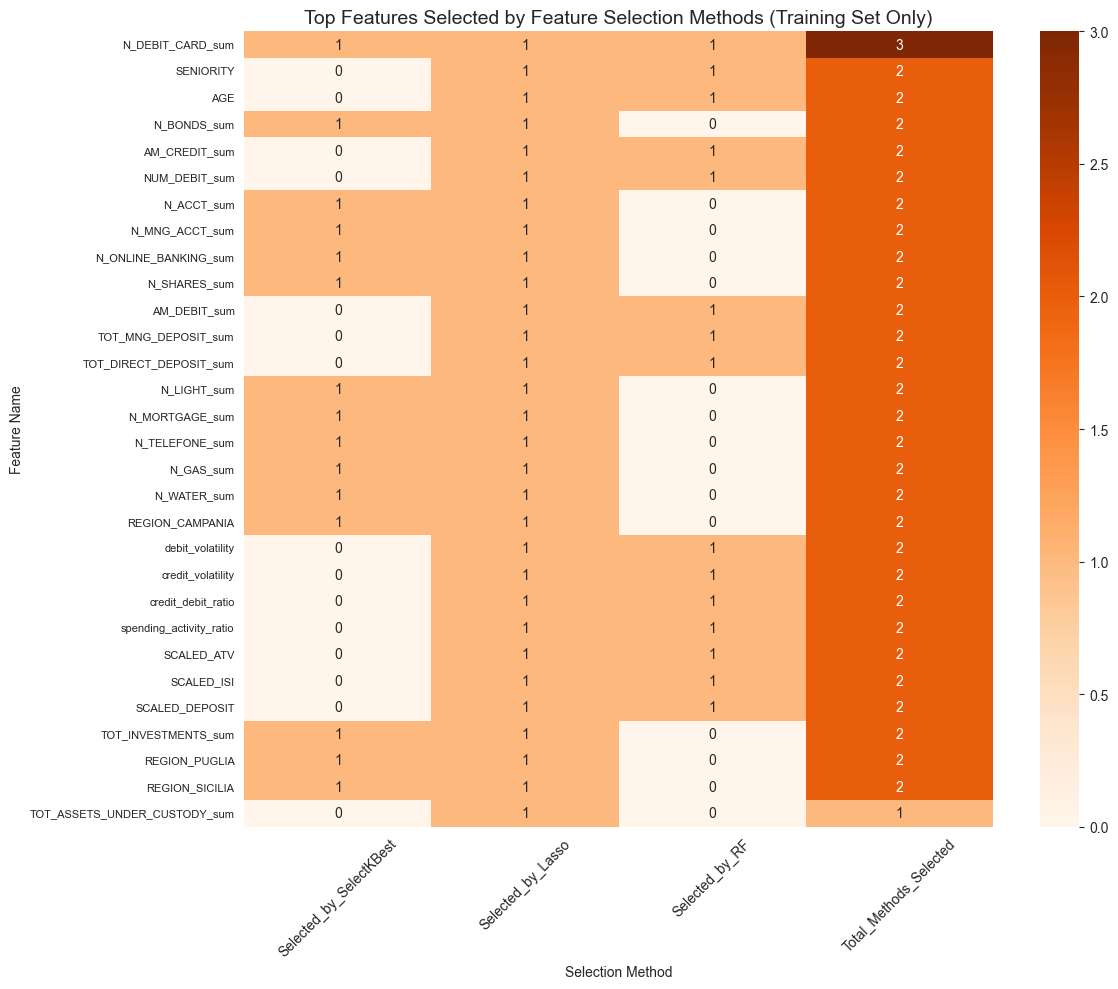

In [198]:
# 1. Recalculate scores using ONLY the training set

# SelectKBest (ANOVA F-test)
skb = SelectKBest(score_func=f_classif, k='all')
skb.fit(X_train, y_train)
skb_scores = pd.Series(skb.scores_, index=X_train.columns)

# Lasso (Logistic Regression with L1 penalty)
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="liblinear", random_state=42)
)
lasso_pipeline.fit(X_train, y_train)
lasso_coef = pd.Series(
    lasso_pipeline.named_steps['logisticregression'].coef_[0],
    index=X_train.columns
)

# Random Forest Importance
rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# 2. Combine scores into DataFrame
feature_scores = pd.DataFrame({
    "SelectKBest_score": skb_scores,
    "Lasso_coef": lasso_coef,
    "RandomForest_importance": rf_importances
})

# 3. Define selection criteria (top 25% or non-zero)
feature_scores["Selected_by_SelectKBest"] = feature_scores["SelectKBest_score"] > feature_scores["SelectKBest_score"].quantile(0.75)
feature_scores["Selected_by_Lasso"] = feature_scores["Lasso_coef"] != 0
feature_scores["Selected_by_RF"] = feature_scores["RandomForest_importance"] > feature_scores["RandomForest_importance"].quantile(0.75)

# 4. Count how many methods selected each feature
feature_scores["Total_Methods_Selected"] = (
    feature_scores["Selected_by_SelectKBest"].astype(int) +
    feature_scores["Selected_by_Lasso"].astype(int) +
    feature_scores["Selected_by_RF"].astype(int)
)

# 5. Sort and prepare for heatmap
feature_scores_sorted = feature_scores.sort_values(by="Total_Methods_Selected", ascending=False)

viz_df = feature_scores_sorted[[  # top 30 features
    "Selected_by_SelectKBest",
    "Selected_by_Lasso",
    "Selected_by_RF",
    "Total_Methods_Selected"
]].head(30).astype(int)

# 6. Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(viz_df, cmap="Oranges", annot=True, cbar=True, fmt='d')
plt.title("Top Features Selected by Feature Selection Methods (Training Set Only)", fontsize=14)
plt.xlabel("Selection Method")
plt.ylabel("Feature Name")
plt.xticks(rotation=45)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


### Visualizing Raw Scores Instead of Binary Selections

Unlike the previous comparison—which focused on **binary selection (selected/not selected)**—this version highlights the **raw importance scores** from each method.

- The top `n` features (e.g., 34) are selected based on total selection counts.
- Raw scores from SelectKBest, Lasso, and Random Forest are **normalized to [0–1]** for fair visual comparison.
- The resulting heatmap shows **both the normalized importance** and the **actual score values**, offering a more granular view of how strongly each method ranks each feature.

This approach emphasizes **score magnitude**, not just agreement, and helps prioritize features with the highest influence across models.


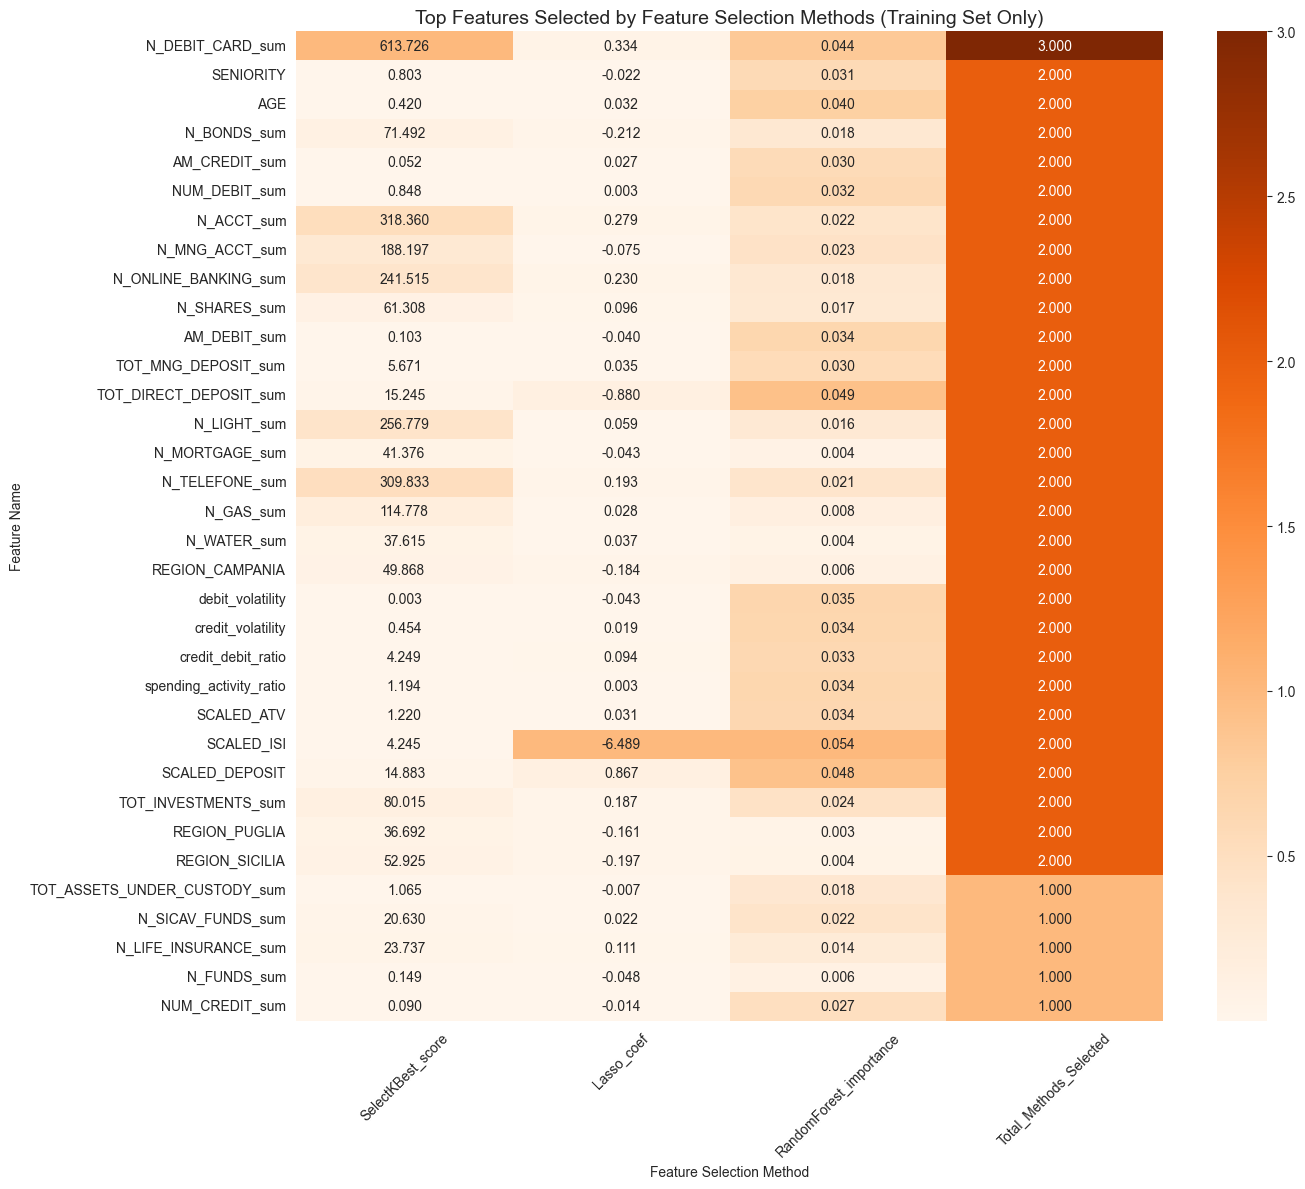

In [ ]:
# Number of top features to visualize
top_n = 34

# Recompute scores using ONLY the training set

# SelectKBest
skb = SelectKBest(score_func=f_classif, k='all')
skb.fit(X_train, y_train)
skb_scores = pd.Series(skb.scores_, index=X_train.columns)

# Lasso
lasso_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty="l1", solver="liblinear", random_state=random_state)
)
lasso_pipeline.fit(X_train, y_train)
lasso_coef = pd.Series(
    lasso_pipeline.named_steps['logisticregression'].coef_[0],
    index=X_train.columns
)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X_train.columns)

# === Combine the scores into a DataFrame
feature_scores = pd.DataFrame({
    "SelectKBest_score": skb_scores,
    "Lasso_coef": lasso_coef,
    "RandomForest_importance": rf_importances
})

# Apply selection rules
feature_scores["Selected_by_SelectKBest"] = feature_scores["SelectKBest_score"] > feature_scores["SelectKBest_score"].quantile(0.75)
feature_scores["Selected_by_Lasso"] = feature_scores["Lasso_coef"] != 0
feature_scores["Selected_by_RF"] = feature_scores["RandomForest_importance"] > feature_scores["RandomForest_importance"].quantile(0.75)

# Count how many methods selected each feature
feature_scores["Total_Methods_Selected"] = (
    feature_scores["Selected_by_SelectKBest"].astype(int) +
    feature_scores["Selected_by_Lasso"].astype(int) +
    feature_scores["Selected_by_RF"].astype(int)
)

# Sort and select top features
feature_scores_sorted = feature_scores.sort_values(by="Total_Methods_Selected", ascending=False)

viz_scores = feature_scores_sorted[[  # raw values
    "SelectKBest_score",
    "Lasso_coef",
    "RandomForest_importance",
    "Total_Methods_Selected"
]].head(top_n)

# Normalize for visual comparison (0-1)
viz_normalized = viz_scores.copy()
viz_normalized["SelectKBest_score"] = viz_normalized["SelectKBest_score"] / viz_normalized["SelectKBest_score"].max()
viz_normalized["Lasso_coef"] = abs(viz_normalized["Lasso_coef"]) / abs(viz_normalized["Lasso_coef"]).max()
viz_normalized["RandomForest_importance"] = viz_normalized["RandomForest_importance"] / viz_normalized["RandomForest_importance"].max()

# Plot heatmap with raw score annotations
plt.figure(figsize=(14, 12))
sns.heatmap(
    viz_normalized,
    cmap="Oranges",
    annot=viz_scores.round(3),
    fmt=".3f",
    cbar=True
)
plt.title("Top Features Selected by Feature Selection Methods (Training Set Only)", fontsize=14)
plt.xlabel("Feature Selection Method")
plt.ylabel("Feature Name")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Dropping irrelevant columns

We retain only the features that were selected by **at least two out of three methods**, increasing confidence in their predictive value.

This filtering step helps:
- Reduce dimensionality
- Focus the model on the most informative signals
- Improve generalization by excluding weaker features

The training set is then updated to include only these high-confidence features.


In [200]:
# Get features selected by at least 2 methods (from training set analysis)
selected_features = feature_scores[feature_scores["Total_Methods_Selected"] >= 2].index.tolist()

# Filter the training set to keep only selected features
X_train_filtered = X_train[selected_features]

# Check dimensions
print("Original number of features in training set:", X_train.shape[1])
print("Selected features (by >= 2 methods):", len(selected_features))
print("Filtered training set shape:", X_train_filtered.shape)


Original number of features in training set: 59
Selected features (by >= 2 methods): 29
Filtered training set shape: (9968, 29)


# Sparsity Analysis: Identifying Sparse Features

To better understand the structure of the selected features, we compute the **percentage of zero values** in each column of the training set.

This analysis helps:

- Detect features that are **highly sparse**, i.e., mostly zeros
- Identify potential **low-activity or rarely triggered behaviors**
- Guide further decisions such as:
  - Removing extremely sparse features (if uninformative)
  - Applying transformations (e.g., binarization or grouping)

Sparse features can reduce model effectiveness or interpretability if they carry little signal. Evaluating their prevalence is a key step in refining the final feature set.


In [201]:
# Calculate the percentage of zeros in each column (on training set only)
zero_percent = (X_train_filtered == 0).sum() / X_train_filtered.shape[0]

# Display the most sparse features
print("Most sparse features in the training set (percentage of zeros):")
print(zero_percent.sort_values(ascending=False).head(33))


Most sparse features in the training set (percentage of zeros):
REGION_PUGLIA              0.951244
REGION_SICILIA             0.950742
N_WATER_sum                0.945927
N_ONLINE_BANKING_sum       0.910915
REGION_CAMPANIA            0.888343
N_MORTGAGE_sum             0.882123
N_GAS_sum                  0.857143
N_SHARES_sum               0.764246
N_BONDS_sum                0.656501
N_LIGHT_sum                0.638844
N_TELEFONE_sum             0.637841
TOT_INVESTMENTS_sum        0.636437
TOT_MNG_DEPOSIT_sum        0.395165
N_DEBIT_CARD_sum           0.303070
credit_volatility          0.200843
AM_CREDIT_sum              0.197231
credit_debit_ratio         0.197231
debit_volatility           0.144663
AM_DEBIT_sum               0.142556
NUM_DEBIT_sum              0.142556
SCALED_ATV                 0.142556
spending_activity_ratio    0.136738
N_MNG_ACCT_sum             0.063604
N_ACCT_sum                 0.048154
SCALED_ISI                 0.034711
SCALED_DEPOSIT             0.033608


# Removing Overly Sparse Features

To improve model efficiency and reduce noise, we remove features that are **too sparse**—those with more than **90% zero values** in the training set.

Why this matters:
- Extremely sparse features often carry **little predictive signal**
- They may introduce **instability** or unnecessary complexity during training
- Dropping them helps simplify the model and reduce the risk of overfitting

This step ensures that the final feature set is not only informative, but also dense enough to be reliably learned by the model.


In [202]:
# Set threshold for sparsity
sparse_threshold = 0.90

# Identify columns with more than 90% zeros (on training set only)
sparse_cols = zero_percent[zero_percent > sparse_threshold].index.tolist()

# Drop sparse columns from the training set
X_train_filtered = X_train_filtered.drop(columns=sparse_cols)

# Output summary
print(f"Removed {len(sparse_cols)} overly sparse columns from the training set.")
print("Updated shape of training set:", X_train_filtered.shape)


Removed 4 overly sparse columns from the training set.
Updated shape of training set: (9968, 25)


# SMOTE:

### Balancing the Target Classes with SMOTE

The target variable in this problem is **imbalanced**, meaning one class (e.g., no credit card) occurs much more frequently than the other.  
Training a model on imbalanced data can lead to **biased predictions** toward the majority class and poor performance on the minority class.


#### What is SMOTE?

**SMOTE (Synthetic Minority Over-sampling Technique)** addresses class imbalance by generating **synthetic samples** for the minority class instead of simply duplicating existing ones.

- It creates new data points by **interpolating between real minority class examples** in feature space.
- This results in a more balanced dataset while maintaining **diversity and generalization**.


#### What Happens in the Code?

1. `SMOTE()` is initialized with a fixed `random_state` for reproducibility.
2. It is applied **only to the training set** (`X_train_filtered`, `y_train`) to avoid data leakage.
3. The method outputs a **resampled training set** with a balanced distribution of target classes.
4. A quick check confirms the new class proportions, ensuring that the model will now receive equal exposure to both classes during training.

This step is crucial for improving **recall**, **F1-score**, and overall fairness of the model—especially when predicting rare events like credit card ownership.

In [203]:
# Initialize SMOTE
smote = SMOTE(random_state=random_state)

# Apply SMOTE to the filtered training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_filtered, y_train)

# Display new class distribution
print("Balanced class distribution (after SMOTE on training set):")
print(pd.Series(y_train_resampled).value_counts())


Balanced class distribution (after SMOTE on training set):
TARGET_CREDIT_CARD
0    6526
1    6526
Name: count, dtype: int64


# ALIGNINIG THE TEST SET WITH THE FINAL TRAINING FEATURES:

After transforming the training set through feature selection and sparsity filtering, it is essential to apply **the same transformations to the test set** to ensure consistency.


### What Happens Here and Why It Matters:

1. **Apply the same feature selection**:  
   We retain only the features previously selected based on the training set analysis.  
   This ensures the model only sees the same information during inference as it saw during training.

2. **Drop sparse columns**:  
   Columns identified as overly sparse in the training set are also removed from the test set.  
   This avoids including features that the model was not trained to interpret.

3. **Align column order**:  
   We explicitly reorder the test set’s columns to match the order of the training set.  
   This is crucial, especially for models like logistic regression or neural networks, where **feature order directly impacts predictions**.

Ensuring **structural parity** between training and test data is a critical step for maintaining the model’s validity and performance at inference time.



In [204]:
# 1. Apply same feature selection
X_test_filtered = X_test[selected_features]

# 2. Drop sparse columns
X_test_filtered = X_test_filtered.drop(columns=sparse_cols, errors='ignore')

# 3. Align column order
X_test_filtered = X_test_filtered[X_train_filtered.columns]


In [205]:
print(X_train_resampled.shape)
print(y_train_resampled.shape)
print(X_test_filtered.shape)
print(y_test.shape)

(13052, 25)
(13052,)
(4273, 25)
(4273,)


# MODELING:

## Model Training & Evaluation

This section implements and evaluates multiple machine learning models to predict customer credit card ownership based on behavioral, demographic, and financial features.

Each model is wrapped in a **pipeline** with a `StandardScaler`, ensuring that all features are properly normalized before training—especially important for algorithms sensitive to feature scale.


### Models Used and Why

#### 1. **Logistic Regression**
- **Type**: Linear classifier
- **Why it’s used**:  
  - Serves as a transparent, interpretable baseline
  - Works well with **linearly separable** features
  - Coefficients offer insights into feature contributions
- **Enhancements**:  
  - `class_weight='balanced'` mitigates class imbalance
  - Scaling improves coefficient stability

#### 2. **Random Forest**
- **Type**: Ensemble of decision trees (bagging)
- **Why it’s used**:  
  - Captures **non-linear patterns** and **feature interactions**
  - Naturally handles missing values and outliers
  - Provides feature importance scores
- **Adjustments**:  
  - Uses 200 trees and class weighting for better generalization

#### 3. **Gradient Boosting**
- **Type**: Sequential ensemble (boosting)
- **Why it’s used**:  
  - Excellent performance on structured/tabular data
  - Learns from errors iteratively, reducing bias
- **Trade-off**:  
  - Slower training; sensitive to hyperparameters

#### 4. **XGBoost**
- **Type**: Optimized gradient boosting framework
- **Why it’s used**:  
  - Highly efficient and robust
  - Supports regularization and sparse data natively
  - Commonly used in real-world winning ML solutions
- **Note**: `eval_metric='logloss'` ensures proper evaluation during training

#### 5. **Decision Tree**
- **Type**: Single decision tree
- **Why it’s used**:  
  - Simple and interpretable
  - Useful as a quick baseline
- **Limitation**:  
  - High risk of overfitting without constraints or ensembling


### Evaluation Strategy

Each model is trained on the **resampled training set** (using SMOTE) and evaluated on the untouched **filtered test set**. The key metrics include:

- **ROC AUC (Receiver Operating Characteristic - Area Under the Curve)**:  
  Measures the model's ability to distinguish between the two classes across all possible thresholds.  
  It is particularly valuable in **imbalanced classification problems**, where accuracy may be misleading.  
  For example, if 90% of customers don't own a credit card, a model that always predicts "no" would achieve 90% accuracy—yet fail completely at identifying the actual adopters.  
  ROC AUC instead evaluates **ranking quality**, helping assess how well the model prioritizes true positives over false ones.

- **Precision**: Accuracy of positive predictions (how many predicted credit card holders actually have one)

- **Recall**: Ability to identify actual credit card holders (true positive rate)

- **F1-score**: Harmonic mean of precision and recall; balances false positives and false negatives

In this context, **ROC AUC** is the most reliable global metric to compare models, especially when class distributions are skewed and decision thresholds may vary depending on business needs.

The final results are collected into a table and sorted by **ROC AUC**, highlighting the most effective models for this classification task.


| Model                             | Test?      | Main reason                                                 |
|-----------------------------------|------------|-------------------------------------------------------------|
| Logistic Regression              | Yes        | Simple, interpretable, common baseline for propensity scoring|
| Random Forest                    | Yes        | Robust, strong performance, provides feature importances    |
| Gradient Boosting (e.g., XGBoost) | Yes       | High performance, widely used in CRM, handles complex features|
| Decision Tree (single)           | Optional   | Interpretable but prone to overfitting; less stable than RF |
| K-Nearest Neighbors              | Optional   | Less interpretable, sensitive to scaling and noise; usually less useful |
| Support Vector Machine (SVM)      | No         | Not scalable for large datasets, computationally expensive  |
| Naive Bayes                       | No         | Assumes independence among features (unrealistic), generally lower performance |


In [206]:
# Define selected models in pipelines
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=random_state, class_weight='balanced'))
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(n_estimators=200, random_state=42))
    ]),
    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", xgb.XGBClassifier(n_estimators=200, random_state=random_state, use_label_encoder=False, eval_metric='logloss'))
    ]),
    "Decision Tree": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", DecisionTreeClassifier(random_state=random_state, class_weight='balanced'))
    ])
}

# Train and evaluate each model
results = []

for name, model in models.items():
    print(f"Training and evaluating: {name}")
    
    # Train on resampled training set
    model.fit(X_train_resampled, y_train_resampled)
    
    # Predict on untouched test set
    y_pred = model.predict(X_test_filtered)
    y_proba = model.predict_proba(X_test_filtered)[:, 1]

    # Evaluation metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"]
    })

# Display results sorted by ROC AUC
results_df = pd.DataFrame(results).sort_values(by="ROC AUC", ascending=False)
print("\nModel comparison:")
print(results_df)


Training and evaluating: Logistic Regression
Training and evaluating: Random Forest
Training and evaluating: Gradient Boosting
Training and evaluating: XGBoost


c:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:32:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training and evaluating: Decision Tree

Model comparison:
                 Model   ROC AUC  Precision    Recall  F1-score
1        Random Forest  0.714518   0.544370  0.494580  0.518282
2    Gradient Boosting  0.704476   0.521771  0.487127  0.503854
0  Logistic Regression  0.693561   0.480131  0.597561  0.532448
3              XGBoost  0.692982   0.513848  0.477642  0.495084
4        Decision Tree  0.583102   0.440497  0.504065  0.470142


### Comparing Models With and Without SMOTE

This block repeats the same training and evaluation process **without applying SMOTE** to the training set.  
The goal is to **assess the real impact of class balancing** on model performance.


#### Key Differences:
- **Previous version**: Trained on a **resampled, balanced dataset** using SMOTE.
- **This version**: Trains directly on the **original, imbalanced training set**.


#### Why This Matters:
By comparing models trained **with and without SMOTE**, we can:
- Quantify how much class imbalance was affecting performance
- Validate whether synthetic oversampling improves **recall** and **F1-score** for the minority class
- Make more informed decisions about **preprocessing strategies** in future iterations

This type of comparison is essential to evaluate whether balancing techniques like SMOTE provide **measurable benefits** or introduce trade-offs.


In [207]:
# Use the same test set as before 
# X_test_filtered already exists with aligned columns

# Define the models
models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(random_state=random_state, class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=random_state, class_weight='balanced'))
    ]),
    "Gradient Boosting": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(n_estimators=200, random_state=random_state))
    ]),
    "XGBoost": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", xgb.XGBClassifier(n_estimators=200, random_state=random_state, use_label_encoder=False, eval_metric='logloss'))
    ]),
    "Decision Tree": Pipeline([
        ("scaler", StandardScaler()),
        ("clf", DecisionTreeClassifier(random_state=random_state, class_weight='balanced'))
    ])
}

# Train and evaluate without SMOTE
results_no_smote = []

for name, model in models.items():
    print(f"Training and evaluating (no SMOTE): {name}")
    
    model.fit(X_train_filtered, y_train)  # NO SMOTE HERE
    
    y_pred = model.predict(X_test_filtered)
    y_proba = model.predict_proba(X_test_filtered)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    results_no_smote.append({
        "Model": name,
        "ROC AUC": roc_auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"]
    })

# Display results
results_df_no_smote = pd.DataFrame(results_no_smote).sort_values(by="ROC AUC", ascending=False)
print("\nModel comparison (without SMOTE):")
print(results_df_no_smote)

Training and evaluating (no SMOTE): Logistic Regression
Training and evaluating (no SMOTE): Random Forest
Training and evaluating (no SMOTE): Gradient Boosting
Training and evaluating (no SMOTE): XGBoost


c:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [08:32:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training and evaluating (no SMOTE): Decision Tree

Model comparison (without SMOTE):
                 Model   ROC AUC  Precision    Recall  F1-score
1        Random Forest  0.721940   0.624818  0.289973  0.396113
2    Gradient Boosting  0.720582   0.583226  0.306233  0.401599
3              XGBoost  0.703455   0.539346  0.413279  0.467971
0  Logistic Regression  0.698826   0.485416  0.597561  0.535682
4        Decision Tree  0.579955   0.450169  0.449864  0.450017


# TUNING RANDOM FOREST:

### Hyperparameter Tuning: Optimizing the Random Forest

After evaluating baseline models, we now fine-tune the **Random Forest classifier** to improve its predictive performance.  
This process, known as **hyperparameter tuning**, is essential for getting the most out of any model.


### Why Hyperparameter Tuning?

Unlike model parameters learned during training (e.g., feature weights), **hyperparameters** are configuration settings defined *before* training begins.  
They govern the model’s structure, complexity, and learning process.

Tuning allows us to:
- Boost model performance (e.g., ROC AUC)
- Avoid underfitting or overfitting
- Adapt the model’s behavior to our specific dataset


### How It Works: `GridSearchCV`

We use **Grid Search with Cross-Validation** (`GridSearchCV`) to explore multiple combinations of hyperparameters and identify the best configuration.

- **`cv=5`** → The training set is split into 5 folds; each fold is used once for validation, while the others are used for training.
- **`scoring='roc_auc'`** → We evaluate each configuration using the ROC AUC metric.
- **`n_jobs=-1`** → Runs in parallel across all available CPU cores.
- **`verbose=2`** → Shows detailed progress output.

Tuning is performed on the **SMOTE-resampled training set** to maintain class balance during model optimization.


### Pipeline Components

- **`StandardScaler()`**: Standardizes features to zero mean and unit variance (important for numerical stability, even if RF is not scale-sensitive).
- **`RandomForestClassifier()`**: Ensemble model made of decision trees with randomness injected to improve generalization.


### Hyperparameters Tuned

Below are the hyperparameters we explore and their role in controlling the model’s structure and behavior:

| Hyperparameter            | Description |
|---------------------------|-------------|
| `n_estimators`            | Number of trees in the forest. More trees → more stable, but slower. |
| `max_depth`               | Maximum depth of each tree. Controls complexity. Shallower trees generalize better; deeper trees may overfit. |
| `min_samples_split`       | Minimum number of samples required to split an internal node. Higher values = more conservative splits. |
| `min_samples_leaf`        | Minimum number of samples required to be at a leaf node. Prevents small leaves, which often lead to overfitting. |
| `max_features`            | Number of features to consider when looking for the best split. `'sqrt'` (default) works well in most cases; `'log2'` is more restrictive. |


### Final Output

At the end of the search:
- `grid_search_rf.best_params_` returns the **optimal hyperparameter combination**
- `grid_search_rf.best_score_` shows the **best average ROC AUC** across the cross-validation folds

This step ensures the Random Forest is not only powerful, but also well-calibrated to our specific dataset and objective.


In [208]:
# Pipeline WITHOUT SMOTE
pipeline_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=random_state, class_weight='balanced'))
])

# Hyperparameter grid
param_grid_rf = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 5, 10, 15],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

# Grid Search on training set (resampled with SMOTE)
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit to TRAINING SET already resampled
grid_search_rf.fit(X_train_resampled, y_train_resampled)

# Report best results
print("Best hyperparameters:", grid_search_rf.best_params_)
print("Best ROC AUC (CV on train):", grid_search_rf.best_score_)


Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best hyperparameters: {'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}
Best ROC AUC (CV on train): 0.851217094804257


# TUNING XGBOOST:

### Hyperparameter Tuning: XGBoost Classifier

In this step, we optimize an **XGBoost classifier**, a high-performance gradient boosting algorithm well-suited for structured/tabular data.


### Why XGBoost?

XGBoost (Extreme Gradient Boosting) is known for:
- High accuracy and efficiency
- Built-in regularization to prevent overfitting
- Excellent handling of both **linear and non-linear patterns**
- Native support for **missing values** and **sparse features**

It's widely adopted in competitions (like Kaggle) and production environments due to its **speed**, **robustness**, and **predictive power**.


### Why Tune It?

XGBoost exposes several hyperparameters that strongly influence its performance.  
By tuning them with `GridSearchCV`, we aim to:
- Boost **ROC AUC**
- Balance **bias vs. variance**
- Control overfitting while maintaining flexibility

We use 5-fold **cross-validation** and `roc_auc` as the scoring metric, making the optimization fair and robust, especially under class imbalance.


### Pipeline and Cross-Validation

- Wrapped in a `Pipeline` with `StandardScaler` for consistent preprocessing.
- SMOTE was already applied beforehand, so no rebalancing is done here.
- `GridSearchCV` runs across all CPU cores (`n_jobs=-1`) and reports verbose output.


### Hyperparameters Tuned

| Hyperparameter         | Description |
|------------------------|-------------|
| `n_estimators`         | Number of boosting rounds (trees). More trees → better fit, but slower and risk of overfitting. |
| `max_depth`            | Maximum tree depth. Controls model complexity. Lower values prevent overfitting. |
| `learning_rate`        | Shrinks the contribution of each tree. Lower = slower learning but often better generalization. |
| `subsample`            | Fraction of training rows used per tree. Helps reduce variance and improve robustness. |
| `colsample_bytree`     | Fraction of features (columns) sampled per tree. Encourages feature diversity and regularization. |

Tuning combinations of these hyperparameters allows XGBoost to adapt better to the **specific noise, sparsity, and patterns** of our dataset.


### Output

- `grid_search_xgb.best_params_` → Best hyperparameter set found across all tested combinations
- `grid_search_xgb.best_score_` → Best average **ROC AUC** across the 5 CV folds on the **resampled training set**

This careful tuning process ensures that XGBoost is calibrated to deliver its full predictive power—without overfitting or underfitting.


In [209]:
# Create pipeline (no SMOTE, since it's applied already)
pipeline_xgb = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", xgb.XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=random_state
    ))
])

# Define parameter grid for tuning
param_grid_xgb = {
    "clf__n_estimators": [100, 200, 300],
    "clf__max_depth": [3, 5, 7],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__subsample": [0.7, 0.8, 1.0],
    "clf__colsample_bytree": [0.7, 0.8, 1.0]
}

# Set up GridSearchCV using ROC AUC and 5-fold CV
grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit ONLY on the training set that was SMOTE-resampled
grid_search_xgb.fit(X_train_resampled, y_train_resampled)

# Print results
print("Best hyperparameters for XGBoost:", grid_search_xgb.best_params_)
print("Best cross-validated ROC AUC (training set):", grid_search_xgb.best_score_)


Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\hp\OneDrive\Desktop\BBS\IP_courses\ML field work lab\PROPENSITY SCORING\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:07:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters for XGBoost: {'clf__colsample_bytree': 0.7, 'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 300, 'clf__subsample': 0.8}
Best cross-validated ROC AUC (training set): 0.8386821687640629


# TUNING GRADIENT BOOSTING:

### Hyperparameter Tuning: Gradient Boosting Classifier (GB)

In this step, we optimize a **Gradient Boosting Classifier**, a powerful and flexible ensemble method based on the principle of boosting — combining multiple weak learners sequentially, where each one corrects the errors of the previous.


### Why Use Gradient Boosting?

Gradient Boosting is especially effective for:
- Capturing **complex non-linear patterns**
- Handling both numeric and categorical features (after encoding)
- Achieving **state-of-the-art performance** on tabular datasets
- Allowing fine control over **bias–variance trade-off** through tuning

It's often a strong contender when balancing performance and interpretability in business contexts.


### Pipeline and Grid Search Setup

The model is wrapped in a `Pipeline` that includes:
- **`StandardScaler()`**: Ensures numeric stability and consistency, especially useful when comparing across pipelines
- **`GradientBoostingClassifier()`**: The core model to be tuned

We apply **`GridSearchCV`** with:
- **5-fold cross-validation** to evaluate generalization
- **`roc_auc`** as scoring metric, more appropriate than accuracy in imbalanced settings
- **Parallel computation** for faster execution (`n_jobs=-1`)


### Hyperparameters Tuned

| Hyperparameter            | Description |
|---------------------------|-------------|
| `n_estimators`            | Number of boosting rounds (trees). More rounds → greater capacity, longer training. |
| `learning_rate`           | Shrinks the contribution of each tree. Lower values increase robustness but require more trees. |
| `max_depth`               | Maximum depth of each individual tree. Controls model complexity and risk of overfitting. |
| `subsample`               | Fraction of training data used per boosting iteration. Values <1.0 introduce randomness for regularization. |
| `min_samples_split`       | Minimum number of samples required to split an internal node. Higher values make the model more conservative. |

These hyperparameters collectively define how **aggressive or conservative** the model is in learning from the data.


### Understanding the Output

Once the grid search is complete, we extract:

- **Best Model Pipeline**:  
  ```python
  grid_search_gb.best_estimator_


In [210]:
# Create pipeline: scaler + GradientBoosting
pipeline_gb = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", GradientBoostingClassifier(random_state=random_state))
])

# Hyperparameter grid to search
param_grid_gb = {
    "clf__n_estimators": [100, 200],
    "clf__learning_rate": [0.05, 0.1],
    "clf__max_depth": [3, 5],
    "clf__subsample": [0.8, 1.0],
    "clf__min_samples_split": [2, 5]
}

# GridSearchCV setup
grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit to TRAINING SET (already resampled with SMOTE)
grid_search_gb.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [3, 5],
                         'clf__min_samples_split': [2, 5],
                         'clf__n_estimators': [100, 200],
                         'clf__subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=2)

# FINAL EVALUATION ON TEST SET:

After fine-tuning our top models, we now evaluate their **generalization ability** on the **hold-out test set**, which was never seen during training or validation.

This provides an **unbiased estimate** of real-world performance and helps us compare the final models side-by-side using meaningful metrics.


### What Happens Here?

- We extract the best-tuned version of each model from its `GridSearchCV` search:
  - `Random Forest`
  - `XGBoost`
  - `Gradient Boosting`

- Each model is tested on the **same test set**, and we compute:
  - **ROC AUC**: Overall ability to rank positives above negatives
  - **Precision**: Accuracy of positive predictions (focuses on false positives)
  - **Recall**: Coverage of actual positives (focuses on false negatives)
  - **F1-score**: Harmonic mean of precision and recall — ideal when classes are imbalanced


### How to Read the Results (Real Output)

| Model              | ROC AUC | Precision | Recall | F1-score |
|--------------------|---------|-----------|--------|----------|
| Random Forest      | 0.718   | 0.540     | 0.486  | 0.511    |
| Gradient Boosting  | 0.710   | 0.525     | 0.489  | 0.506    |
| XGBoost            | 0.708   | 0.520     | 0.476  | 0.497    |

#### Interpretation:

- **ROC AUC**:  
  All three models are reasonably close, with **Random Forest (0.718)** performing best.  
  This means it is slightly better at **ranking** true positives ahead of false positives across all thresholds.

- **Precision & Recall**:  
  - Precision is modest (~0.52–0.54), meaning around **half of the customers predicted to have a credit card actually do**.
  - Recall is slightly lower (~0.48), indicating the models are retrieving **less than half of the true positives**.  
  This reflects the inherent difficulty of the task — likely due to data imbalance or subtle predictive patterns.

- **F1-score**:  
  Balanced between precision and recall, the F1-scores suggest that all three models perform **similarly**, with **Random Forest slightly ahead**.


### Summary & Next Steps

- While performance is **not exceptionally high**, Random Forest shows the **most balanced behavior** across metrics.
- XGBoost and Gradient Boosting are close behind, and might improve with further tuning or feature engineering.
- These results provide a solid basis for:
  - Selecting the final model for deployment
  - Calibrating thresholds based on business priorities (e.g., favoring recall vs. precision)
  - Considering ensembling strategies to combine strengths


In [211]:
# Retrieve best estimators from each GridSearchCV
best_rf = grid_search_rf.best_estimator_
best_xgb = grid_search_xgb.best_estimator_
best_gb = grid_search_gb.best_estimator_

# Define models dictionary
models = {
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "Gradient Boosting": best_gb
}

# Evaluate each model on the test set
final_results = []

for name, model in models.items():
    print(f"\nEvaluating {name} on the TEST set:")

    y_pred = model.predict(X_test_filtered)
    y_proba = model.predict_proba(X_test_filtered)[:, 1]

    auc = roc_auc_score(y_test, y_proba)
    report = classification_report(y_test, y_pred, output_dict=True)

    final_results.append({
        "Model": name,
        "ROC AUC": auc,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1-score": report["1"]["f1-score"]
    })

# Show final comparison
results_df = pd.DataFrame(final_results).sort_values(by="ROC AUC", ascending=False)
print("\nFinal model comparison (on TEST set):")
print(results_df)




Evaluating Random Forest on the TEST set:

Evaluating XGBoost on the TEST set:

Evaluating Gradient Boosting on the TEST set:

Final model comparison (on TEST set):
               Model   ROC AUC  Precision    Recall  F1-score
0      Random Forest  0.718158   0.539910  0.485772  0.511412
2  Gradient Boosting  0.710334   0.525091  0.489160  0.506489
1            XGBoost  0.707771   0.520000  0.475610  0.496815


# FEATURE IMPORTANCE:

### Feature Importance Analysis (Random Forest)

After training and tuning our best-performing Random Forest model, we now examine which features have the greatest influence on its decisions.


### Why Analyze Feature Importance?

Understanding feature importance allows us to:
- Gain **transparency** into the model’s decision-making process
- Validate whether the model is leveraging **business-relevant variables**
- Identify potential **redundancies or noise** in the data
- Provide valuable **insights to stakeholders** (e.g., which customer attributes most impact credit card ownership)


### What Happens in This Cell?

1. We extract the trained model from the pipeline using `best_rf.named_steps["clf"]`.
2. We retrieve the `.feature_importances_` attribute from the Random Forest classifier.
   - This is based on how much each feature **reduces impurity (Gini index)** across all trees.
3. We match the importances to their feature names using the training set columns.
4. The top 15 features are printed and visualized with a horizontal bar chart for clarity.


### How to Interpret the Chart

The bar chart shows the **top 15 most important features** used by the Random Forest model.

| Example Feature         | What It Represents                            | Interpretation |
|-------------------------|------------------------------------------------|----------------|
| `N_DEBIT_CARD_sum`      | Total debit card usage                        | Customers with more debit card activity may be more likely to engage in financial products (or already embedded in the system). |
| `SCALED_ISI`            | Income Stability Index (scaled)              | Income stability is a strong signal of financial reliability and spending potential. |
| `TOT_DIRECT_DEPOSIT_sum`| Total amount of salary or income deposited   | Higher deposits likely reflect stronger or more consistent cash flows. |
| `AGE`                   | Customer age                                  | Age may reflect eligibility, life stage, or financial maturity. |
| `N_TELEFONE_sum`        | Utility bill payments via the bank           | Suggests engagement with services and banking ecosystem. |
| `debit_volatility`      | Fluctuation in debit activity                | Could reflect lifestyle irregularity or lack of financial discipline. |
| `spending_activity_ratio`| Normalized transaction activity             | High transaction volume per month may reflect financial activity level or digital usage. |

Features near the top of the chart have the most **predictive power**, while those at the bottom contribute less to the model's decisions.


### Practical Takeaways

- The model is **heavily influenced by behavioral and transactional patterns**, such as card usage, deposits, and payment activity — more than by demographic variables alone.
- **Income stability and transaction regularity** (e.g., `SCALED_ISI`, `debit_volatility`) are strong signals.
- The presence of utility payment features (`N_TELEFONE_sum`) shows that **non-obvious variables** can carry predictive value, perhaps serving as proxies for engagement or financial habits.
- The chart also helps identify which features could be most useful for **feature selection**, **marketing segmentation**, or **explainable AI** tools.


### Conclusion

This step bridges **model performance** with **human interpretability**, providing a transparent view of how the Random Forest model reaches its predictions — a critical aspect for trust, accountability, and business communication.

Top 15 most important features:
                    Feature  Importance
10         N_DEBIT_CARD_sum    0.074917
18               SCALED_ISI    0.068920
14   TOT_DIRECT_DEPOSIT_sum    0.063427
17           SCALED_DEPOSIT    0.062723
0                       AGE    0.051810
13           N_TELEFONE_sum    0.051581
15      TOT_MNG_DEPOSIT_sum    0.047176
22         debit_volatility    0.045963
23        credit_volatility    0.044090
19               SCALED_ATV    0.043690
16      TOT_INVESTMENTS_sum    0.043308
21  spending_activity_ratio    0.043183
2              AM_DEBIT_sum    0.043088
1                 SENIORITY    0.042026
3             AM_CREDIT_sum    0.041890


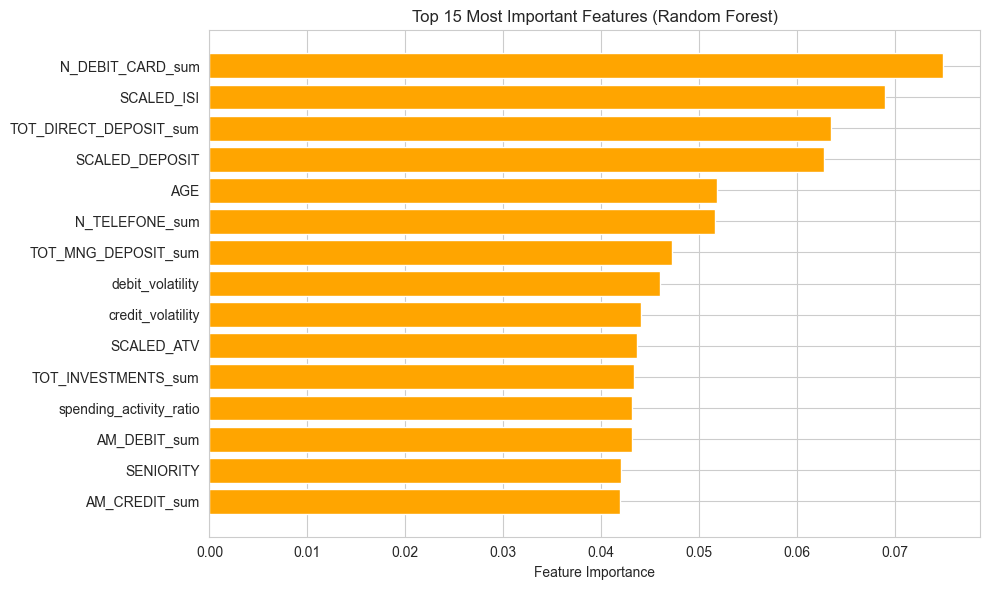

In [212]:
best_rf = grid_search_rf.best_estimator_

# Get feature importances from the classifier inside the pipeline
importances = best_rf.named_steps["clf"].feature_importances_

# Get feature names from the training set
feature_names = X_train_filtered.columns

# Combine into a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Display top 15 features
print("Top 15 most important features:")
print(importance_df.head(15))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(15)['Feature'], importance_df.head(15)['Importance'], color='orange')
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()


# CONFUSION MATRIX:

### Understanding Prediction Errors

To complement metric-based evaluation (e.g. ROC AUC, F1-score), we visualize the **confusion matrix** for the Random Forest model on the test set.  
This provides a **detailed breakdown** of correct and incorrect predictions across both classes.


### Why Use a Confusion Matrix?

While metrics like AUC give an overall performance snapshot, the **confusion matrix** answers deeper questions:
- What type of errors is the model making?
- Is it better at identifying one class than the other?
- Are false positives or false negatives more problematic?

This is especially useful in **imbalanced classification**.


### What Happens in the Code?

- We use `ConfusionMatrixDisplay.from_estimator()` to plot the matrix directly from the trained model.
- The matrix compares **true labels** (`y_test`) with **predicted labels**.
- We apply a heatmap style for intuitive visualization.


### How to Read This Confusion Matrix

| True Class | Predicted 0 | Predicted 1 |
|------------|-------------|-------------|
| **Class 0** (no credit card) | **2186** (TN) | **611** (FP) |
| **Class 1** (has credit card) | **759** (FN) | **717** (TP) |

- **True Positives (TP = 717)**: Correctly predicted customers with a credit card.
- **True Negatives (TN = 2186)**: Correctly predicted customers without a credit card.
- **False Positives (FP = 611)**: Predicted credit card holders who actually don’t have one.
- **False Negatives (FN = 759)**: Missed credit card holders.


### Interpretation of the Results

- The model is **reasonably good at identifying non-holders** (Class 0):  
  ~78% of actual non-holders (2186 out of 2797) were classified correctly.
- However, it **struggles more with Class 1 (card holders)**:
  - It misses **759** customers who actually own a credit card → this is a **recall issue**.
  - It also makes **611 false alarms**, predicting ownership where there is none → impacts **precision**.

This confirms the trade-off: the model prioritizes **conservative classification**, slightly favoring avoiding false positives at the cost of **missing true positives**.


### Why This Step Matters

The confusion matrix:
- Gives an intuitive **error profile** of the model
- Helps decide **where to act**:
  - If recall is more important (e.g., don’t miss a potential client), you might lower the decision threshold
  - If precision matters more (e.g., avoid false campaigns), threshold can be increased
- Serves as a foundation for threshold optimization, cost-sensitive learning, or business rule integration

Use this alongside ROC curves, precision-recall curves, and threshold tuning to build a **balanced and actionable model strategy**.

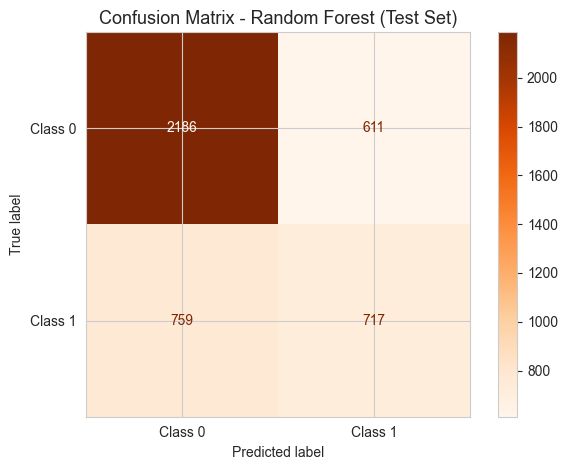

In [213]:
# Plot confusion matrix with orange tones
ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test_filtered,
    y_test,
    cmap="Oranges",
    display_labels=["Class 0", "Class 1"]
)
plt.title("Confusion Matrix - Random Forest (Test Set)", fontsize=13)
plt.tight_layout()
plt.show()


# ROC CURVE:

### ROC Curve – Random Forest (Test Set)

In this step, we plot the **ROC curve** for the best Random Forest model, evaluated on the **test set**.


### What Is the ROC Curve?

The ROC curve visualizes the **performance of a binary classifier across all possible classification thresholds**.

- **X-axis (False Positive Rate)**: Proportion of actual negatives incorrectly classified as positive.
- **Y-axis (True Positive Rate / Recall)**: Proportion of actual positives correctly identified.

A perfect model would rise vertically to the top-left corner (0,1) and reach AUC = 1.  
A random model would follow the diagonal line (AUC = 0.5).


### Why Plot It?

The ROC curve:
- Shows how the model balances **sensitivity (recall)** vs. **fallout (false positive rate)**
- Allows comparison of multiple models regardless of decision threshold
- Is especially useful when classes are **imbalanced**, as it avoids being biased by class prevalence


### How to Interpret This Plot

- The **orange line** represents the ROC curve of our Random Forest.
- The curve bows **well above the diagonal**, indicating **better-than-random performance**.
- The **AUC = 0.72**, meaning that:
The model has a 72% probability of ranking a randomly chosen positive instance higher than a randomly chosen negative one.

#### Key Insights:
- AUC between **0.7 and 0.8** is generally considered **acceptable/good** in complex real-world scenarios.
- The curve shows that the model is able to **retain a decent recall** while **not overwhelming the system with false positives** — especially in the mid-threshold range.

---

### Practical Takeaway

The ROC curve confirms that:
- Our Random Forest model can **separate the two classes reasonably well**.
- There's still room to **optimize the classification threshold** to improve recall or precision, depending on business needs.
- This diagnostic view is essential for making informed decisions about **model deployment and threshold tuning**.

We can use this curve alongside **precision-recall analysis** to define the best trade-off for our use case (e.g., maximize recall for customer acquisition or precision for fraud detection).


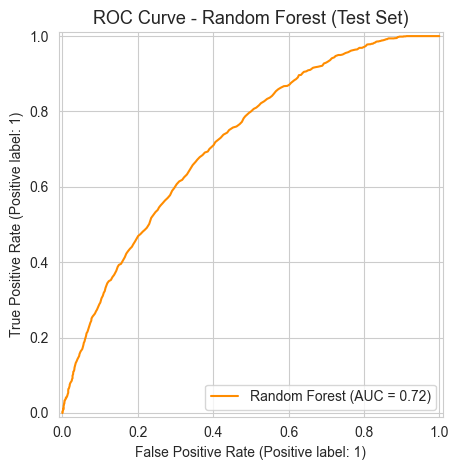

In [214]:
# Plot ROC curve with orange line
roc_display = RocCurveDisplay.from_estimator(
    best_rf,
    X_test_filtered,
    y_test,
    name="Random Forest",
    color="darkorange"
)
plt.title("ROC Curve - Random Forest (Test Set)", fontsize=13)
plt.tight_layout()
plt.show()


# OUTPUT:

## Final Output: Customer-Level Propensity Scores

The ultimate goal of this project is to predict **how likely each customer is to adopt a new credit card** — a classic **propensity modeling** use case in the banking sector.


### What Are Propensity Scores?

Using the final, tuned Random Forest model, we calculate for each customer in the test set the **probability of belonging to class 1**, i.e., **having a credit card**.  
This score — called the **propensity score** — is a value between 0 and 1, where:

- **Closer to 1** → High likelihood of owning (or being eligible/interested in) a credit card
- **Closer to 0** → Low likelihood


### What Does This Output Show?

| Customer_ID | Propensity_Score | Prediction |
|-------------|------------------|------------|
| 13262       | 0.496            | Low        |
| 7112        | 0.520            | Medium     |
| 7954        | 0.640            | Medium     |
| ...         | ...              | ...        |

Each row represents a customer from the test set and includes:
- Their **predicted probability** of class 1 (`Propensity_Score`)
- A **qualitative label** based on defined thresholds:
  - **High**: ≥ 0.80
  - **Medium**: 0.50 – 0.79
  - **Low**: < 0.50

This makes the output not only technically accurate, but also **actionable** for non-technical stakeholders.


### Why Is This Step Important?

1. **Bridges the gap between model and business**:  
   Instead of binary predictions (0/1), we return a **ranked probability**, which supports smarter decision-making (e.g., marketing, risk scoring, personalization).

2. **Enables prioritization**:  
   - Customers with **High** scores could be **targeted aggressively** in campaigns.
   - **Medium** scores could be monitored or incentivized further.
   - **Low** scores may be excluded or handled with cost-efficient strategies.

3. **Supports segmentation**:  
   The qualitative categories (Low/Medium/High) allow for **easy filtering, visualization, and reporting**, and align with business terminology.


### How to Use It Practically

- **Sort by `Propensity_Score`** to build ranked customer lists.
- Combine with CRM data to personalize offers.
- Use thresholds flexibly depending on **marketing budget** or **conversion capacity**.

This final DataFrame transforms raw predictions into a **propensity-based targeting tool** that can directly inform strategy, campaigns, and customer engagement decisions.


In [215]:
# Compute propensity scores (probability of class 1)
propensity_scores = best_rf.predict_proba(X_test_filtered)[:, 1]

# Define qualitative thresholds
def categorize_score(score):
    if score >= 0.8:
        return "High"
    elif score >= 0.5:
        return "Medium"
    else:
        return "Low"

# Create the final output DataFrame
output_df = pd.DataFrame({
    "Customer_ID": X_test_filtered.index,  # Adjust if you have a Customer_ID column instead
    "Propensity_Score": propensity_scores
})

output_df["Prediction"] = output_df["Propensity_Score"].apply(categorize_score)

# Sort descending by score
#output_df = output_df.sort_values(by="Propensity_Score", ascending=False)

# Display the top 10
print(output_df.head(10))

   Customer_ID  Propensity_Score Prediction
0        13262          0.496667        Low
1         1036          0.276667        Low
2         7112          0.520000     Medium
3         5687          0.543333     Medium
4         9362          0.513333     Medium
5         7954          0.640000     Medium
6         7414          0.523333     Medium
7        12834          0.313333        Low
8         5788          0.170000        Low
9         5283          0.296667        Low


# PROJECT SUMMARY

**Project Title**:  
**Propensity Modeling for Credit Card Adoption**

**Objective**:  
To build a machine learning pipeline capable of predicting each customer's likelihood of acquiring a new credit card, using behavioral, demographic, and financial features.  
The final output enables data-driven customer segmentation and personalized marketing strategies based on propensity scores.

**Tools & Technologies**:
- Python (pandas, scikit-learn, etc.)
- Jupyter / Visual Studio Code / Colab
- Data preprocessing, feature engineering, model tuning, evaluation, and deployment-ready scoring


### Project Team

- **[Chatbi Marwane]** – marwane.chatbi@studio.unibo.it
- **[Citterio Elisa]** – elisa.citterio@studio.unibo.it
- **[Longo Luca]** – luca.longo7@studio.unibo.it
- **[Malizia Franco]** – franco.malizia@studio.unibo.it
- **[Tran Manh Duc]** – manhduc.tran@studio.unibo.it




### Date & Context

- **Institution**: [BBS / ANALYTICSNETWORK / AI & Innovation Management / CRM-Propensity Scoring]
- **Course / Department**: ["Machine Learning Lab"]
- **Completion Date**: [13 Aprile 2025]


### Notes

- Dataset anonymized and derived from real banking operations (simulated for academic purposes).
- All models evaluated under strict train/test separation and class balancing procedures.
- Further improvements may include threshold optimization, business calibration, or model deployment.